In [1]:
import matplotlib
# %matplotlib inline
from pylab import *
import caesar
import h5py, os
import yt, pickle
from scipy.optimize import curve_fit
from scipy.stats import binned_statistic as bst
from scipy.stats import binned_statistic_2d as bst2
from lmfit.models import LinearModel, StepModel
from scipy.signal import savgol_filter as sgf
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, InsetPosition, mark_inset

matplotlib.rcParams['xtick.labelsize'] = 18
matplotlib.rcParams['ytick.labelsize'] = 18

step_mod = StepModel(form='erf', prefix='step_')
line_mod = LinearModel(prefix='line_') 

import astropy.units as u

from astropy.cosmology import LambdaCDM, z_at_value
cosm=LambdaCDM(Om0=0.3,Ode0=0.7,H0=68)
uniage=cosm.age(0).value
uniage

/usr/lib/python3.8/_collections_abc.py:666: MatplotlibDeprecationWarning: The global colormaps dictionary is no longer considered public API.
  self[key]


13.863071710210757

In [2]:
class tracking_pg(object):
    def __init__(self, ids,startsn=151,endsn=14):
        path='../../'+sim+'/'+wind+'/' 
        nsnap=startsn-endsn+1
        self.snapnumber=np.arange(startsn,endsn-1,-1)
        self.reds=np.zeros(nsnap,dtype=float)

        # fill_progentor_data()
        for i,sn in enumerate(self.snapnumber):
            exts='000'+str(sn)
            if wind == 's50nojet' and sn in [94, 95]:
                continue
            tmpg = caesar.load(path+'Groups/'+sim+'_'+exts[-3:]+'.hdf5')
            
            if i == 0:
                if isinstance(ids, type('a')):
                    if ids == 'center':
                        cidf=np.array([l.central for l in tmpg.galaxies])
                        ids = np.where(cidf==True)[0]  # note that obj.galaxies[1000].GroupID == 1000
                self.gids = ids
                self.bhmasses=np.zeros((nsnap, ids.size),dtype=float)
                self.bhmdot = np.zeros((nsnap, ids.size),dtype=float)
                self.bh_fedd= np.zeros((nsnap, ids.size),dtype=float)
                self.stellarmasses=np.zeros((nsnap, ids.size),dtype=float)
                self.stellarmasses_2HMR=np.zeros((nsnap, ids.size),dtype=float)
                self.central=np.ones((nsnap, ids.size,),dtype=np.bool)
                self.HImasses=np.zeros((nsnap, ids.size),dtype=float)
                self.H2masses=np.zeros((nsnap, ids.size),dtype=float)
                self.gasmasses=np.zeros((nsnap, ids.size),dtype=float)
                self.sfr=np.zeros((nsnap, ids.size),dtype=float)
#                 self.angular_momentum_all=np.zeros((nsnap, ids.size),dtype=float)
                self.stellar_metallicity=np.zeros((nsnap, ids.size),dtype=float)
                self.stellar_velocity_dispersion=np.zeros((nsnap, ids.size),dtype=float)
                self.stellar_velocity_dispersion_HMR=np.zeros((nsnap, ids.size),dtype=float)
                self.stellar_half_mass_radii=np.zeros((nsnap, ids.size),dtype=float)
                self.local_mass_density=np.zeros((nsnap, ids.size),dtype=float)
                self.local_number_density=np.zeros((nsnap, ids.size),dtype=float)

                self.progen_index=np.zeros((nsnap, ids.size),dtype=np.int64)-1
                self.haloIDs=np.zeros((nsnap, ids.size),dtype=np.int64)
                self.halomasses_HI=np.zeros((nsnap, ids.size),dtype=float)-1
                self.halomasses_H2=np.zeros((nsnap, ids.size),dtype=float)-1
                self.halomasses_stellar=np.zeros((nsnap, ids.size),dtype=float)-1
                self.halomasses_fof=np.zeros((nsnap, ids.size),dtype=float)-1
                self.halomasses_gas=np.zeros((nsnap, ids.size),dtype=float)-1
                
                self.abs_sdss_g=np.zeros((nsnap, ids.size),dtype=float)+99
                self.abs_sdss_r=np.zeros((nsnap, ids.size),dtype=float)+99
                self.app_sdss_g=np.zeros((nsnap, ids.size),dtype=float)+99
                self.app_sdss_r=np.zeros((nsnap, ids.size,),dtype=float)+99

                self.abs_sdss_g_nodust=np.zeros((nsnap, ids.size),dtype=float)+99
                self.abs_sdss_r_nodust=np.zeros((nsnap, ids.size),dtype=float)+99
                self.app_sdss_g_nodust=np.zeros((nsnap, ids.size),dtype=float)+99
                self.app_sdss_r_nodust=np.zeros((nsnap, ids.size),dtype=float)+99
            
            self.reds[i]=tmpg.simulation.redshift
            if sn == startsn:
                for j, jid in enumerate(ids):
                    self.bhmasses[i,j] = tmpg.galaxies[jid].masses['bh']
                    self.bhmdot[i,j] = tmpg.galaxies[jid].bhmdot
                    self.bh_fedd[i,j] = tmpg.galaxies[jid].bh_fedd
                    self.stellarmasses[i,j] = tmpg.galaxies[jid].masses['stellar']
                    self.central[i,j] = tmpg.galaxies[jid].central
                    self.HImasses[i,j] = tmpg.galaxies[jid].masses['HI']
                    self.H2masses[i,j] = tmpg.galaxies[jid].masses['H2']
                    self.gasmasses[i,j] = tmpg.galaxies[jid].masses['gas']
                    self.sfr[i,j] = tmpg.galaxies[jid].sfr
                    self.stellar_metallicity[i,j] = tmpg.galaxies[jid].metallicities['stellar']
                    self.stellar_velocity_dispersion[i,j] = tmpg.galaxies[jid].velocity_dispersions["stellar"]
                    self.stellar_half_mass_radii[i,j] = tmpg.galaxies[jid].radii["stellar_half_mass"]
                    self.local_mass_density[i,j] = tmpg.galaxies[jid].local_mass_density['3000']
                    self.local_number_density[i,j] = tmpg.galaxies[jid].local_number_density['3000']
                    
                    self.progen_index[i,j] = tmpg.galaxies[jid].progen_galaxy_star[0]
                    self.haloIDs[i,j] = tmpg.galaxies[jid].parent_halo_index
                    if self.haloIDs[i,j]>-0.5:
                        self.halomasses_HI[i,j] = tmpg.halos[self.haloIDs[i,j]].masses['HI']
                        self.halomasses_H2[i,j] = tmpg.halos[self.haloIDs[i,j]].masses['H2']
                        self.halomasses_stellar[i,j] = tmpg.halos[self.haloIDs[i,j]].masses['stellar']
                        self.halomasses_fof[i,j] = tmpg.halos[self.haloIDs[i,j]].masses['total']
                        self.halomasses_gas[i,j] = tmpg.halos[self.haloIDs[i,j]].masses['gas']
                    
                    self.abs_sdss_g[i,j] = tmpg.galaxies[jid].absmag['sdss_g']
                    self.abs_sdss_r[i,j] = tmpg.galaxies[jid].absmag['sdss_r']
                    self.app_sdss_g[i,j] = tmpg.galaxies[jid].appmag['sdss_g']
                    self.app_sdss_r[i,j] = tmpg.galaxies[jid].appmag['sdss_r']
                    self.abs_sdss_g_nodust[i,j] = tmpg.galaxies[jid].absmag_nodust['sdss_g']
                    self.abs_sdss_r_nodust[i,j] = tmpg.galaxies[jid].absmag_nodust['sdss_r']
                    self.app_sdss_g_nodust[i,j] = tmpg.galaxies[jid].appmag_nodust['sdss_g']
                    self.app_sdss_r_nodust[i,j] = tmpg.galaxies[jid].appmag_nodust['sdss_r']
            else:
                for j, jid in enumerate(self.progen_index[i-1,:]):
                    if (jid != -1) and ('bh' in  tmpg.galaxies[jid].masses.keys()):
                        self.bhmasses[i,j] = tmpg.galaxies[jid].masses['bh']
                        self.bhmdot[i,j] = tmpg.galaxies[jid].bhmdot
                        self.bh_fedd[i,j] = tmpg.galaxies[jid].bh_fedd
                        self.stellarmasses[i,j] = tmpg.galaxies[jid].masses['stellar']
                        self.central[i,j] = tmpg.galaxies[jid].central
                        self.HImasses[i,j] = tmpg.galaxies[jid].masses['HI']
                        self.H2masses[i,j] = tmpg.galaxies[jid].masses['H2']
                        self.gasmasses[i,j] = tmpg.galaxies[jid].masses['gas']
                        self.sfr[i,j] = tmpg.galaxies[jid].sfr
                        if hasattr(tmpg.galaxies[jid], 'metallicities'):
                            if 'stellar' in tmpg.galaxies[jid].metallicities.keys():
                                self.stellar_metallicity[i,j] = tmpg.galaxies[jid].metallicities['stellar']
                        self.stellar_velocity_dispersion[i,j] = tmpg.galaxies[jid].velocity_dispersions["stellar"]
                        self.stellar_half_mass_radii[i,j] = tmpg.galaxies[jid].radii["stellar_half_mass"]
                        self.local_mass_density[i,j] = tmpg.galaxies[jid].local_mass_density['3000']
                        self.local_number_density[i,j] = tmpg.galaxies[jid].local_number_density['3000']

                        self.progen_index[i,j] = tmpg.galaxies[jid].progen_galaxy_star[0]
                        self.haloIDs[i,j] = tmpg.galaxies[jid].parent_halo_index
                        if self.haloIDs[i,j]>-0.5:
                            self.halomasses_HI[i,j] = tmpg.halos[self.haloIDs[i,j]].masses['HI']
                            self.halomasses_H2[i,j] = tmpg.halos[self.haloIDs[i,j]].masses['H2']
                            self.halomasses_stellar[i,j] = tmpg.halos[self.haloIDs[i,j]].masses['stellar']
                            self.halomasses_fof[i,j] = tmpg.halos[self.haloIDs[i,j]].masses['total']
                            self.halomasses_gas[i,j] = tmpg.halos[self.haloIDs[i,j]].masses['gas']
                        
                        if hasattr(tmpg.galaxies[jid], 'absmag'):
                            if 'sdss_g' in tmpg.galaxies[jid].absmag.keys():
                                self.abs_sdss_g[i,j] = tmpg.galaxies[jid].absmag['sdss_g']
                                self.abs_sdss_r[i,j] = tmpg.galaxies[jid].absmag['sdss_r']
                                self.app_sdss_g[i,j] = tmpg.galaxies[jid].appmag['sdss_g']
                                self.app_sdss_r[i,j] = tmpg.galaxies[jid].appmag['sdss_r']
                                self.abs_sdss_g_nodust[i,j] = tmpg.galaxies[jid].absmag_nodust['sdss_g']
                                self.abs_sdss_r_nodust[i,j] = tmpg.galaxies[jid].absmag_nodust['sdss_r']
                                self.app_sdss_g_nodust[i,j] = tmpg.galaxies[jid].appmag_nodust['sdss_g']
                                self.app_sdss_r_nodust[i,j] = tmpg.galaxies[jid].appmag_nodust['sdss_r']         
            del(tmpg)

# Load data and catalog

In [3]:
M200m=np.load('data/m100n1024_s50_m200m.npy') #load m200 mean
M200m.shape

(35843,)

In [4]:
with open('data/tracking_center_m100n1024_s50.class', 'rb') as rf:
    track_cm100n1024 = pickle.load(rf)

In [5]:
with open('data/tracking_center_m50n512_s50nox.class', 'rb') as rf:
    track_cm50nox = pickle.load(rf)
M200m50nox=np.load('data/m50n512_s50nox_m200m.npy')

In [6]:
with open('data/tracking_center_m50n512_s50.class', 'rb') as rf:
    track_cm50 = pickle.load(rf)
M200m50=np.load('data/m50n512_s50_m200m.npy')

In [7]:
with open('data/tracking_center_m25n512_s50.class', 'rb') as rf:
    track_cm25 = pickle.load(rf)
M200m25=np.load('data/m25n512_s50_m200m.npy')

In [8]:
with open('data/tracking_center_m50n512_s50nojet.class', 'rb') as rf:
    track_cm50nojet = pickle.load(rf)
M200m50nojet=np.load('data/m50n512_s50nojet_m200m.npy')

In [9]:
idmc100=track_cm100n1024.stellarmasses[0,:]>1.0e10
idmc95=track_cm100n1024.stellarmasses[0,:]>10**9.5
idmc50=track_cm50.stellarmasses[0,:]>1.0e10
idmc50nox=track_cm50nox.stellarmasses[0,:]>1.0e10

In [10]:
# load data from Randelbaum+2016
Rred=np.loadtxt('data/Mandelbaum16-red.txt')
Rblue=np.loadtxt('data/Mandelbaum16-blue.txt')
#\log10 M*_eff [M_sun] \log10 M*^MPA_eff [M_sun]  \log10 M_200 [M_sun/h] with h=0.673 +err -err 

Mred=np.loadtxt('data/MaoS2011-red.txt',delimiter=',')
Mblue=np.loadtxt('data/MaoS2011-blue.txt',delimiter=',')
#M*, Mh with h^-1 up, middle, down  

In [12]:
#  see the Cal-quching-formation-times.py file for the calculation of Formation/Quenching times for all halos and central galaxies
# we only load the data from that calcualtion
FoQum100=np.load('data/QFT-central-0.1-m100n1024-s50.npz')['arr_0']
## ID, BH mass, Galaxy mass, Halo mass [0-3], BH qt, Galaxy qt, galaxy *-gas crossing time, Halo ft, Halo half z (fit, smooth, data)
## [scale factor 4-11] [Universe age 11-18] [redshift 18-25] !! New added[25-28] galaxy M*-MHI+MHII crossing time
##   !! Another new added [28-31] galaxy half mass a/time, age, redshift
# FoQum50=np.load('data/QFT-central-0.1-m50n512-s50.npz')['arr_0']

# FoQum50nox=np.load('data/QFT-central-0.1-m50n512-s50nox.npz')['arr_0']
# Difference between FoQu and FoQu05 is very small

In [13]:
uni_a=cosm.age(track_cm100n1024.reds[::-1]).value ##in Gyr, all sims should be the same
sc_a=1/(1+track_cm100n1024.reds[::-1]) 
reds=track_cm100n1024.reds[::-1]

# Fig 1

In [14]:
def sel_color_red(gmrc,Ms):  ## note here we use a slightly lower slope to separate red/blue galaxies because the ICL is generaly younger than BCG and it is not separated out.
    idred1=((gmrc - 0.65)/(np.log10(Ms*0.71**2)-10)>=0.07)&(np.log10(Ms*0.71**2)>=10)
    idred2=((gmrc - 0.65)/(np.log10(Ms*0.71**2)-10)<0.07)&(np.log10(Ms*0.71**2)<10)
    return idred1 | idred2

gmr_color0=track_cm100n1024.abs_sdss_g[0,:]-track_cm100n1024.abs_sdss_r[0,:]

idred = sel_color_red(gmr_color0, track_cm100n1024.stellarmasses[0,:])

Text(0, 0.5, 'g -r')

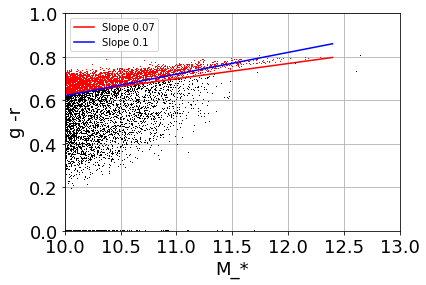

In [15]:
# M* - color relation comparing the 0.1 slope with 0.07 slope
plot(np.log10(track_cm100n1024.stellarmasses[0,:]),track_cm100n1024.abs_sdss_g[0,:]-track_cm100n1024.abs_sdss_r[0,:],'k,')
plot(np.log10(track_cm100n1024.stellarmasses[0,idred]),track_cm100n1024.abs_sdss_g[0,idred]-track_cm100n1024.abs_sdss_r[0,idred],'r,')
Ms=np.arange(10,12.5,0.1)
plot(Ms, 0.65+0.07*(np.log10(10**Ms*0.71**2) - 10), 'r-', label='Slope 0.07')
plot(Ms, 0.65+0.1*(np.log10(10**Ms*0.71**2) - 10), 'b-', label='Slope 0.1')
# (g − r)_cut = 0.65 + 0.10 * (\log (M∗ (h−2 M) − 10.0) # color cut in Ms
xlim(10,13);ylim(0,1)
legend()
grid()
xlabel('M_*',fontsize=18)
ylabel('g -r',fontsize=18)

<ipython-input-16-8efdf0595524>:2: RuntimeWarning: divide by zero encountered in log10
  plot(np.log10(track_cm100n1024.sfr[0,:]/track_cm100n1024.stellarmasses[0,:]*1.0e9),track_cm100n1024.abs_sdss_g[0,:]-track_cm100n1024.abs_sdss_r[0,:],'k,')
<ipython-input-16-8efdf0595524>:3: RuntimeWarning: divide by zero encountered in log10
  plot(np.log10(track_cm100n1024.sfr[0,idred]/track_cm100n1024.stellarmasses[0,idred]*1.0e9),track_cm100n1024.abs_sdss_g[0,idred]-track_cm100n1024.abs_sdss_r[0,idred],'r,')


Text(0, 0.5, 'g-r')

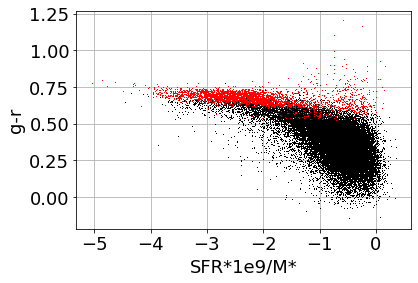

In [16]:
# sSFR - color relation
plot(np.log10(track_cm100n1024.sfr[0,:]/track_cm100n1024.stellarmasses[0,:]*1.0e9),track_cm100n1024.abs_sdss_g[0,:]-track_cm100n1024.abs_sdss_r[0,:],'k,')
plot(np.log10(track_cm100n1024.sfr[0,idred]/track_cm100n1024.stellarmasses[0,idred]*1.0e9),track_cm100n1024.abs_sdss_g[0,idred]-track_cm100n1024.abs_sdss_r[0,idred],'r,')
grid()
xlabel('SFR*1e9/M*', fontsize=18)
ylabel('g-r', fontsize=18)

/home/weiguang/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/weiguang/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


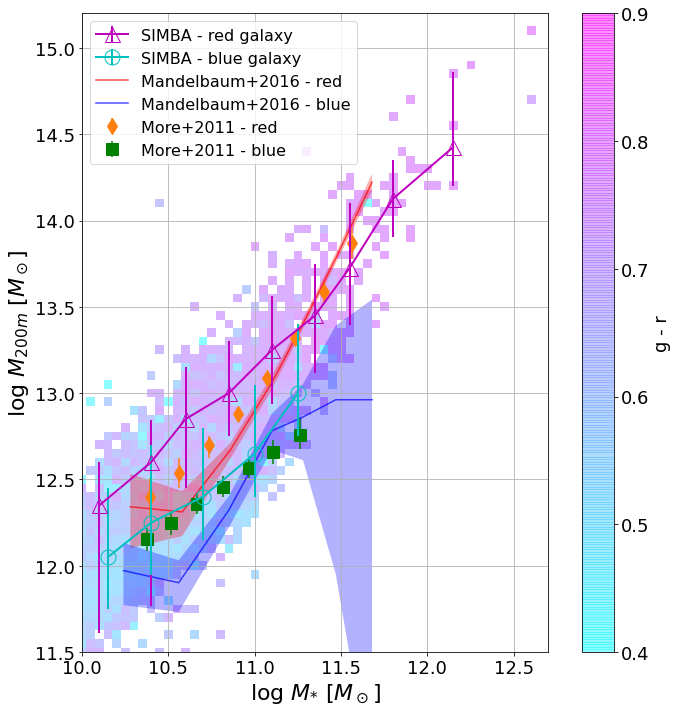

In [18]:
#SIMBA100
fig=figure(figsize=(10,10))

sxlim=[10,12.7]
sylim=[11.5,15.2]
mbs=0.05
nbn=9

ax=subplot(111)

logms = np.log10(track_cm100n1024.stellarmasses[0,idmc100])
logmh = np.log10(M200m[idmc100])

pmmden,xbe,ybe,bn=bst2(logms, logmh, gmr_color0[idmc100], statistic='mean', bins=[np.arange(10,12.7, mbs),np.arange(11.5,15.2, mbs)])
imshow(pmmden.T,origin='lower',cmap='cool',aspect='equal',alpha=0.45,vmin=0.4,vmax=0.9,zorder=-99)


xc,yc=np.mgrid[0:pmmden.shape[0],0:pmmden.shape[1]]
xc=xc.flatten(); yc=yc.flatten(); mreds=np.copy(pmmden.flatten())
idsr=sel_color_red(mreds,10**(xc*mbs+sxlim[0])) # & (mreds>0)
for i,li,cc,msp in zip([[-6,-2],[-2,0]],['red galaxy','blue galaxy'],['m','c'],['^','o']):
    if i[0] == -6:
        ids = idsr
    else:
        ids = ~idsr & (mreds>0)
    x=xc[ids]
    myp=yc[ids]

    plmden,be,bn=bst(x, myp, statistic=lambda y: np.percentile(y, 16), bins=nbn)
    pumden,be,bn=bst(x, myp, statistic=lambda y: np.percentile(y, 84), bins=nbn)
    pmmden,bemden,bn=bst(x, myp, statistic=lambda y: np.percentile(y, 50), bins=nbn)

    bn,bemden,bn2=bst(x, myp, statistic='count', bins=nbn)
    xvd = np.zeros(bemden.size-1)
    for j in range(xvd.size):
        idinb=(x>=bemden[j])&(x<bemden[j+1])
        xvd[j] = np.median(x[idinb])
    if i[1]==0:
        idbn=bn>5
        if not os.path.isfile('data/blue_galaxies_M200m.txt'):
            np.savetxt('data/blue_galaxies_M200m.txt',
                       np.array([xvd[idbn]*mbs+sxlim[0], pmmden[idbn]*mbs+sylim[0], pmmden[idbn]-plmden[idbn],pumden[idbn]-pmmden[idbn]]))
    else:
        idbn=bn>5
        if not os.path.isfile('data/red_galaxies_M200m.txt'):
            np.savetxt('data/red_galaxies_M200m.txt',
                       np.array([xvd[idbn]*mbs+sxlim[0], pmmden[idbn]*mbs+sylim[0], pmmden[idbn]-plmden[idbn],pumden[idbn]-pmmden[idbn]]))
    errorbar(xvd[idbn], pmmden[idbn], np.append(pmmden-plmden,pumden-pmmden).reshape(2,plmden.size)[:,idbn], #yerr=std[idbn],  #
             marker=msp, color=cc, ls='-',lw=2,ms=15,zorder=99, mfc='None', label=r'SIMBA - '+li)

Rred_r=np.copy(Rred); Rred_r[:,0] = (Rred_r[:,0] - sxlim[0])/mbs; Rred_r[:,2] = (Rred_r[:,2] - np.log10(0.673) - sylim[0])/mbs; Rred_r[:,3:5] = Rred_r[:,3:5]/mbs
Rblue_r=np.copy(Rblue); Rblue_r[:,0] = (Rblue_r[:,0] - sxlim[0])/mbs; Rblue_r[:,2] = (Rblue_r[:,2] - np.log10(0.673) - sylim[0])/mbs; Rblue_r[:,3:5] = Rblue_r[:,3:5]/mbs
plot(Rred_r[:,0], Rred_r[:,2], 'r-', label=r'Mandelbaum+2016 - red',alpha=0.7)
plot(Rblue_r[:,0], Rblue_r[:,2], 'b-', label=r'Mandelbaum+2016 - blue',alpha=0.7)
fill_between(Rred_r[:,0], Rred_r[:,2]+Rred_r[:,4], Rred_r[:,2]+Rred_r[:,3], facecolor='red', interpolate=True, alpha=0.3)
fill_between(Rblue_r[:,0], Rblue_r[:,2]+Rblue_r[:,4], Rblue_r[:,2]+Rblue_r[:,3], facecolor='blue', interpolate=True, alpha=0.3)

Mred_r=np.copy(Mred); Mred_r[:,0]=(np.log10(Mred_r[:,0]) - sxlim[0])/mbs; Mred_r[:,3]=(Mred_r[:,2]-Mred_r[:,3])/Mred_r[:,2]/np.log(10)/mbs; 
Mred_r[:,1]=(Mred_r[:,1]-Mred_r[:,2])/Mred_r[:,2]/np.log(10)/mbs; Mred_r[:,2] = (np.log10(Mred_r[:,2])-np.log10(0.673) - sylim[0])/mbs
errorbar(Mred_r[:,0], Mred_r[:,2], yerr=[Mred_r[:,3], Mred_r[:,1]],
         c='tab:orange',ecolor='tab:orange',marker='d',linestyle='none', ms=12, label=r'More+2011 - red')

Mblue_r=np.copy(Mblue); Mblue_r[:,0]=(np.log10(Mblue_r[:,0]) - sxlim[0])/mbs; Mblue_r[:,3]=(Mblue_r[:,2]-Mblue_r[:,3])/Mblue_r[:,2]/np.log(10)/mbs; 
Mblue_r[:,1]=(Mblue_r[:,1]-Mblue_r[:,2])/Mblue_r[:,2]/np.log(10)/mbs; Mblue_r[:,2] = (np.log10(Mblue_r[:,2])-np.log10(0.673) - sylim[0])/mbs
errorbar(Mblue_r[:,0], Mblue_r[:,2],yerr=[Mblue_r[:,3],Mblue_r[:,1]],
         c='g',ecolor='g',marker='s',linestyle='none', ms=12,label=r'More+2011 - blue')

c1=colorbar()
c1.ax.set_ylabel('g - r',fontsize=18)
ylabel(r'$\log\ M_{200m}\ [M_\odot]$', fontsize=22)
xlabel(r'$\log\ M_{*} \ [M_\odot]$', fontsize=22)


ntkb=10
ax.set_ylim(0,ybe.shape[0]); ax.set_xlim(0,xbe.shape[0]); 
ax.set_xticks(np.arange(0,xbe.shape[0]-1, ntkb, dtype=np.int32))
ax.set_yticks(np.arange(0,ybe.shape[0]-1, ntkb, dtype=np.int32)) 
ax.set_yticklabels(np.arange(sylim[0],sylim[1], ntkb*mbs))
ax.set_xticklabels(np.arange(sxlim[0],sxlim[1], ntkb*mbs))

grid()
handles, labels = ax.get_legend_handles_labels()
ax.legend([handles[i] for i in [2,3,0,1,4,5]], [labels[i] for i in [2,3,0,1,4,5]],loc=2,fontsize=16)
# legend(loc=2,fontsize=16)
tight_layout()

savefig('plots/Fig1.pdf',dpi=300)

# Figure 6

/home/weiguang/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/weiguang/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/weiguang/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/weiguang/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


265


/home/weiguang/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/weiguang/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-19-364ed256b8d4>:219: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


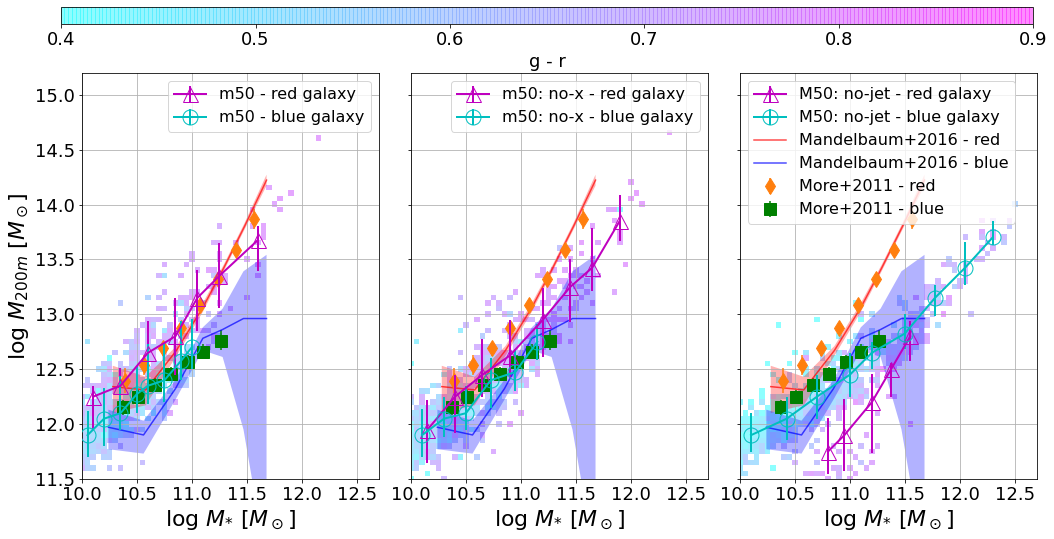

In [19]:
#combined together

fig, (ax1, ax2, ax3) = subplots(1, 3, sharey=True,figsize=(15, 8))

sxlim=[10,12.7]
sylim=[11.5,15.2]
mbs=0.05
nbn=9

# m50
logms = np.log10(track_cm50.stellarmasses[0,:])
logmh = np.log10(M200m50)

pmmden,xbe,ybe,bn=bst2(logms, logmh, track_cm50.abs_sdss_g[0,:]-track_cm50.abs_sdss_r[0,:], statistic='mean', bins=[np.arange(10,12.7, mbs),np.arange(11.5,15.2, mbs)])
ax1.imshow(pmmden.T,origin='lower',cmap='cool',aspect='equal',alpha=0.45,vmin=0.4,vmax=0.9,zorder=-99)

xc,yc=np.mgrid[0:pmmden.shape[0],0:pmmden.shape[1]]
xc=xc.flatten(); yc=yc.flatten(); mreds=np.copy(pmmden.flatten())
idsr=sel_color_red(mreds,10**(xc*mbs+sxlim[0])) # & (mreds>0)
for i,li,cc,msp in zip([[-6,-2],[-2,0]],['red galaxy','blue galaxy'],['m','c'],['^','o']):
    if i[0] == -6:
        ids = idsr
    else:
        ids = ~idsr & (mreds>0)
    x=xc[ids]
    myp=yc[ids]

    plmden,be,bn=bst(x, myp, statistic=lambda y: np.percentile(y, 16), bins=nbn)
    pumden,be,bn=bst(x, myp, statistic=lambda y: np.percentile(y, 84), bins=nbn)
    pmmden,bemden,bn=bst(x, myp, statistic=lambda y: np.percentile(y, 50), bins=nbn)

    bn,bemden,bn2=bst(x, myp, statistic='count', bins=nbn)
    xvd = np.zeros(bemden.size-1)
    for j in range(xvd.size):
        idinb=(x>=bemden[j])&(x<bemden[j+1])
        xvd[j] = np.median(x[idinb])
    if i[1]==0:
        idbn=bn>5
        if not os.path.isfile('data/blue_galaxies_M200m.txt'):
            np.savetxt('data/blue_galaxies_M200m.txt',
                       np.array([xvd[idbn]*mbs+sxlim[0], pmmden[idbn]*mbs+sylim[0], pmmden[idbn]-plmden[idbn],pumden[idbn]-pmmden[idbn]]))
    else:
        idbn=bn>5
        if not os.path.isfile('data/red_galaxies_M200m.txt'):
            np.savetxt('data/red_galaxies_M200m.txt',
                       np.array([xvd[idbn]*mbs+sxlim[0], pmmden[idbn]*mbs+sylim[0], pmmden[idbn]-plmden[idbn],pumden[idbn]-pmmden[idbn]]))
    ax1.errorbar(xvd[idbn], pmmden[idbn], np.append(pmmden-plmden,pumden-pmmden).reshape(2,plmden.size)[:,idbn], #yerr=std[idbn],  #
             marker=msp, color=cc, ls='-',lw=2,ms=15,zorder=99, mfc='None', label=r'm50 - '+li)

Rred_r=np.copy(Rred); Rred_r[:,0] = (Rred_r[:,0] - sxlim[0])/mbs; Rred_r[:,2] = (Rred_r[:,2] - np.log10(0.673) - sylim[0])/mbs; Rred_r[:,3:5] = Rred_r[:,3:5]/mbs
Rblue_r=np.copy(Rblue); Rblue_r[:,0] = (Rblue_r[:,0] - sxlim[0])/mbs; Rblue_r[:,2] = (Rblue_r[:,2] - np.log10(0.673) - sylim[0])/mbs; Rblue_r[:,3:5] = Rblue_r[:,3:5]/mbs
ax1.plot(Rred_r[:,0], Rred_r[:,2], 'r-',alpha=0.7)
ax1.plot(Rblue_r[:,0], Rblue_r[:,2], 'b-', alpha=0.7)
ax1.fill_between(Rred_r[:,0], Rred_r[:,2]+Rred_r[:,4], Rred_r[:,2]+Rred_r[:,3], facecolor='red', interpolate=True, alpha=0.3)
ax1.fill_between(Rblue_r[:,0], Rblue_r[:,2]+Rblue_r[:,4], Rblue_r[:,2]+Rblue_r[:,3], facecolor='blue', interpolate=True, alpha=0.3)

Mred_r=np.copy(Mred); Mred_r[:,0]=(np.log10(Mred_r[:,0]) - sxlim[0])/mbs; Mred_r[:,3]=(Mred_r[:,2]-Mred_r[:,3])/Mred_r[:,2]/np.log(10)/mbs; 
Mred_r[:,1]=(Mred_r[:,1]-Mred_r[:,2])/Mred_r[:,2]/np.log(10)/mbs; Mred_r[:,2] = (np.log10(Mred_r[:,2])-np.log10(0.673) - sylim[0])/mbs
ax1.errorbar(Mred_r[:,0], Mred_r[:,2], yerr=[Mred_r[:,3], Mred_r[:,1]],
         c='tab:orange',ecolor='tab:orange',marker='d',linestyle='none', ms=12)#, label=r'More+2011 - red')

Mblue_r=np.copy(Mblue); Mblue_r[:,0]=(np.log10(Mblue_r[:,0]) - sxlim[0])/mbs; Mblue_r[:,3]=(Mblue_r[:,2]-Mblue_r[:,3])/Mblue_r[:,2]/np.log(10)/mbs; 
Mblue_r[:,1]=(Mblue_r[:,1]-Mblue_r[:,2])/Mblue_r[:,2]/np.log(10)/mbs; Mblue_r[:,2] = (np.log10(Mblue_r[:,2])-np.log10(0.673) - sylim[0])/mbs
ax1.errorbar(Mblue_r[:,0], Mblue_r[:,2],yerr=[Mblue_r[:,3],Mblue_r[:,1]],
         c='g',ecolor='g',marker='s',linestyle='none', ms=12)#,label=r'More+2011 - blue')

# c1=colorbar()
# c1.ax.set_ylabel('g - r',fontsize=18)
ax1.set_ylabel(r'$\log\ M_{200m}\ [M_\odot]$', fontsize=22)
ax1.set_xlabel(r'$\log\ M_{*} \ [M_\odot]$', fontsize=22)
ax1.legend(fontsize=16)

ntkb=10
ax1.set_ylim(0,ybe.shape[0]); ax1.set_xlim(0,xbe.shape[0]); 
ax1.set_xticks(np.arange(0,xbe.shape[0]-1, ntkb, dtype=np.int32))
ax1.set_yticks(np.arange(0,ybe.shape[0]-1, ntkb, dtype=np.int32)) 
ax1.set_yticklabels(np.arange(sylim[0],sylim[1], ntkb*mbs))
ax1.set_xticklabels(np.arange(sxlim[0],sxlim[1], ntkb*mbs))
ax1.grid()


#no X
logms = np.log10(track_cm50nox.stellarmasses[0,:])
logmh = np.log10(M200m50nox)

pmmden,xbe,ybe,bn=bst2(logms, logmh, track_cm50nox.abs_sdss_g[0,:]-track_cm50nox.abs_sdss_r[0,:], statistic='mean', bins=[np.arange(10,12.7, mbs),np.arange(11.5,15.2, mbs)])
ax2.imshow(pmmden.T,origin='lower',cmap='cool',aspect='equal',alpha=0.45,vmin=0.4,vmax=0.9,zorder=-99)

xc,yc=np.mgrid[0:pmmden.shape[0],0:pmmden.shape[1]]
xc=xc.flatten(); yc=yc.flatten(); mreds=np.copy(pmmden.flatten())
idsr=sel_color_red(mreds,10**(xc*mbs+sxlim[0])) # & (mreds>0)
for i,li,cc,msp in zip([[-6,-2],[-2,0]],['red galaxy','blue galaxy'],['m','c'],['^','o']):
    if i[0] == -6:
        ids = idsr
    else:
        ids = ~idsr & (mreds>0)
    x=xc[ids]
    myp=yc[ids]

    plmden,be,bn=bst(x, myp, statistic=lambda y: np.percentile(y, 16), bins=nbn)
    pumden,be,bn=bst(x, myp, statistic=lambda y: np.percentile(y, 84), bins=nbn)
    pmmden,bemden,bn=bst(x, myp, statistic=lambda y: np.percentile(y, 50), bins=nbn)

    bn,bemden,bn2=bst(x, myp, statistic='count', bins=nbn)
    xvd = np.zeros(bemden.size-1)
    for j in range(xvd.size):
        idinb=(x>=bemden[j])&(x<bemden[j+1])
        xvd[j] = np.median(x[idinb])
    if i[1]==0:
        idbn=bn>5
        if not os.path.isfile('data/blue_galaxies_M200m.txt'):
            np.savetxt('data/blue_galaxies_M200m.txt',
                       np.array([xvd[idbn]*mbs+sxlim[0], pmmden[idbn]*mbs+sylim[0], pmmden[idbn]-plmden[idbn],pumden[idbn]-pmmden[idbn]]))
    else:
        idbn=bn>5
        if not os.path.isfile('data/red_galaxies_M200m.txt'):
            np.savetxt('data/red_galaxies_M200m.txt',
                       np.array([xvd[idbn]*mbs+sxlim[0], pmmden[idbn]*mbs+sylim[0], pmmden[idbn]-plmden[idbn],pumden[idbn]-pmmden[idbn]]))
    ax2.errorbar(xvd[idbn], pmmden[idbn], np.append(pmmden-plmden,pumden-pmmden).reshape(2,plmden.size)[:,idbn], #yerr=std[idbn],  #
             marker=msp, color=cc, ls='-',lw=2,ms=15,zorder=99, mfc='None', label=r'm50: no-x - '+li)

Rred_r=np.copy(Rred); Rred_r[:,0] = (Rred_r[:,0] - sxlim[0])/mbs; Rred_r[:,2] = (Rred_r[:,2] - np.log10(0.673) - sylim[0])/mbs; Rred_r[:,3:5] = Rred_r[:,3:5]/mbs
Rblue_r=np.copy(Rblue); Rblue_r[:,0] = (Rblue_r[:,0] - sxlim[0])/mbs; Rblue_r[:,2] = (Rblue_r[:,2] - np.log10(0.673) - sylim[0])/mbs; Rblue_r[:,3:5] = Rblue_r[:,3:5]/mbs
ax2.plot(Rred_r[:,0], Rred_r[:,2], 'r-',alpha=0.7)
ax2.plot(Rblue_r[:,0], Rblue_r[:,2], 'b-',alpha=0.7)
ax2.fill_between(Rred_r[:,0], Rred_r[:,2]+Rred_r[:,4], Rred_r[:,2]+Rred_r[:,3], facecolor='red', interpolate=True, alpha=0.3)
ax2.fill_between(Rblue_r[:,0], Rblue_r[:,2]+Rblue_r[:,4], Rblue_r[:,2]+Rblue_r[:,3], facecolor='blue', interpolate=True, alpha=0.3)

Mred_r=np.copy(Mred); Mred_r[:,0]=(np.log10(Mred_r[:,0]) - sxlim[0])/mbs; Mred_r[:,3]=(Mred_r[:,2]-Mred_r[:,3])/Mred_r[:,2]/np.log(10)/mbs; 
Mred_r[:,1]=(Mred_r[:,1]-Mred_r[:,2])/Mred_r[:,2]/np.log(10)/mbs; Mred_r[:,2] = (np.log10(Mred_r[:,2])-np.log10(0.673) - sylim[0])/mbs
ax2.errorbar(Mred_r[:,0], Mred_r[:,2], yerr=[Mred_r[:,3], Mred_r[:,1]],
         c='tab:orange',ecolor='tab:orange',marker='d',linestyle='none', ms=12)#, label=r'More+2011 - red')

Mblue_r=np.copy(Mblue); Mblue_r[:,0]=(np.log10(Mblue_r[:,0]) - sxlim[0])/mbs; Mblue_r[:,3]=(Mblue_r[:,2]-Mblue_r[:,3])/Mblue_r[:,2]/np.log(10)/mbs; 
Mblue_r[:,1]=(Mblue_r[:,1]-Mblue_r[:,2])/Mblue_r[:,2]/np.log(10)/mbs; Mblue_r[:,2] = (np.log10(Mblue_r[:,2])-np.log10(0.673) - sylim[0])/mbs
ax2.errorbar(Mblue_r[:,0], Mblue_r[:,2],yerr=[Mblue_r[:,3],Mblue_r[:,1]],
         c='g',ecolor='g',marker='s',linestyle='none', ms=12)#,label=r'More+2011 - blue')

# c1=colorbar()
# c1.ax.set_ylabel('g - r',fontsize=18)
# ylabel(r'$\log\ M_{200m}\ [M_\odot]$', fontsize=22)
ax2.set_xlabel(r'$\log\ M_{*} \ [M_\odot]$', fontsize=22)
ax2.legend(fontsize=16)

ntkb=10
ax2.set_ylim(0,ybe.shape[0]); ax2.set_xlim(0,xbe.shape[0]); 
ax2.set_xticks(np.arange(0,xbe.shape[0]-1, ntkb, dtype=np.int32))
ax2.set_yticks(np.arange(0,ybe.shape[0]-1, ntkb, dtype=np.int32)) 
# ax.set_yticklabels(np.arange(sylim[0],sylim[1], ntkb*mbs))
ax2.set_xticklabels(np.arange(sxlim[0],sxlim[1], ntkb*mbs))

ax2.grid()


#no jet
logms = np.log10(track_cm50nojet.stellarmasses[0,:])
logmh = np.log10(M200m50nojet)

pmmden,xbe,ybe,bn=bst2(logms, logmh, track_cm50nojet.abs_sdss_g[0,:]-track_cm50nojet.abs_sdss_r[0,:], statistic='mean', bins=[np.arange(10,12.7, mbs),np.arange(11.5,15.2, mbs)])
im3=ax3.imshow(pmmden.T,origin='lower',cmap='cool',aspect='equal',alpha=0.45,vmin=0.4,vmax=0.9,zorder=-99)

xc,yc=np.mgrid[0:pmmden.shape[0],0:pmmden.shape[1]]
xc=xc.flatten(); yc=yc.flatten(); mreds=np.copy(pmmden.flatten())
idsr=sel_color_red(mreds,10**(xc*mbs+sxlim[0])) # & (mreds>0)
for i,li,cc,msp in zip([[-6,-2],[-2,0]],['red galaxy','blue galaxy'],['m','c'],['^','o']):
    if i[0] == -6:
        ids = idsr
    else:
        ids = ~idsr & (mreds>0)
    x=xc[ids]
    myp=yc[ids]

    plmden,be,bn=bst(x, myp, statistic=lambda y: np.percentile(y, 16), bins=nbn)
    pumden,be,bn=bst(x, myp, statistic=lambda y: np.percentile(y, 84), bins=nbn)
    pmmden,bemden,bn=bst(x, myp, statistic=lambda y: np.percentile(y, 50), bins=nbn)

    bn,bemden,bn2=bst(x, myp, statistic='count', bins=nbn)
    xvd = np.zeros(bemden.size-1)
    for j in range(xvd.size):
        idinb=(x>=bemden[j])&(x<bemden[j+1])
        xvd[j] = np.median(x[idinb])
    idbn=bn>5
    ax3.errorbar(xvd[idbn], pmmden[idbn], np.append(pmmden-plmden,pumden-pmmden).reshape(2,plmden.size)[:,idbn], #yerr=std[idbn],  #
             marker=msp, color=cc, ls='-',lw=2,ms=15,zorder=99, mfc='None', label=r'M50: no-jet - '+li)

Rred_r=np.copy(Rred); Rred_r[:,0] = (Rred_r[:,0] - sxlim[0])/mbs; Rred_r[:,2] = (Rred_r[:,2] - np.log10(0.673) - sylim[0])/mbs; Rred_r[:,3:5] = Rred_r[:,3:5]/mbs
Rblue_r=np.copy(Rblue); Rblue_r[:,0] = (Rblue_r[:,0] - sxlim[0])/mbs; Rblue_r[:,2] = (Rblue_r[:,2] - np.log10(0.673) - sylim[0])/mbs; Rblue_r[:,3:5] = Rblue_r[:,3:5]/mbs
ax3.plot(Rred_r[:,0], Rred_r[:,2], 'r-', label=r'Mandelbaum+2016 - red',alpha=0.7)
ax3.plot(Rblue_r[:,0], Rblue_r[:,2], 'b-', label=r'Mandelbaum+2016 - blue',alpha=0.7)
ax3.fill_between(Rred_r[:,0], Rred_r[:,2]+Rred_r[:,4], Rred_r[:,2]+Rred_r[:,3], facecolor='red', interpolate=True, alpha=0.3)
ax3.fill_between(Rblue_r[:,0], Rblue_r[:,2]+Rblue_r[:,4], Rblue_r[:,2]+Rblue_r[:,3], facecolor='blue', interpolate=True, alpha=0.3)

Mred_r=np.copy(Mred); Mred_r[:,0]=(np.log10(Mred_r[:,0]) - sxlim[0])/mbs; Mred_r[:,3]=(Mred_r[:,2]-Mred_r[:,3])/Mred_r[:,2]/np.log(10)/mbs; 
Mred_r[:,1]=(Mred_r[:,1]-Mred_r[:,2])/Mred_r[:,2]/np.log(10)/mbs; Mred_r[:,2] = (np.log10(Mred_r[:,2])-np.log10(0.673) - sylim[0])/mbs
ax3.errorbar(Mred_r[:,0], Mred_r[:,2], yerr=[Mred_r[:,3], Mred_r[:,1]],
         c='tab:orange',ecolor='tab:orange',marker='d',linestyle='none', ms=12, label=r'More+2011 - red')

Mblue_r=np.copy(Mblue); Mblue_r[:,0]=(np.log10(Mblue_r[:,0]) - sxlim[0])/mbs; Mblue_r[:,3]=(Mblue_r[:,2]-Mblue_r[:,3])/Mblue_r[:,2]/np.log(10)/mbs; 
Mblue_r[:,1]=(Mblue_r[:,1]-Mblue_r[:,2])/Mblue_r[:,2]/np.log(10)/mbs; Mblue_r[:,2] = (np.log10(Mblue_r[:,2])-np.log10(0.673) - sylim[0])/mbs
ax3.errorbar(Mblue_r[:,0], Mblue_r[:,2],yerr=[Mblue_r[:,3],Mblue_r[:,1]],
         c='g',ecolor='g',marker='s',linestyle='none', ms=12,label=r'More+2011 - blue')

ax3.set_xlabel(r'$\log\ M_{*} \ [M_\odot]$', fontsize=22)

cax1 = axes([0.06, 0.94, 0.9, 0.03])
c1=colorbar(im3,cax=cax1,orientation='horizontal')
c1.ax.set_xlabel('g - r',fontsize=18)

ntkb=10
ax3.set_ylim(0,ybe.shape[0]); ax3.set_xlim(0,xbe.shape[0]); 
ax3.set_xticks(np.arange(0,xbe.shape[0]-1, ntkb, dtype=np.int32))
ax3.set_yticks(np.arange(0,ybe.shape[0]-1, ntkb, dtype=np.int32)) 
ax3.set_xticklabels(np.arange(sxlim[0],sxlim[1], ntkb*mbs))

ax3.grid()
handles, labels = ax3.get_legend_handles_labels()
ax3.legend([handles[i] for i in [2,3,0,1,4,5]], [labels[i] for i in [2,3,0,1,4,5]],loc=2,fontsize=16)
fig.tight_layout()
savefig('plots/M50.pdf',dpi=300)

# Fig. 2

In [20]:
redgal=np.loadtxt('./data/red_galaxies_MFoF.txt')
blugal=np.loadtxt('./data/blue_galaxies_MFoF.txt')

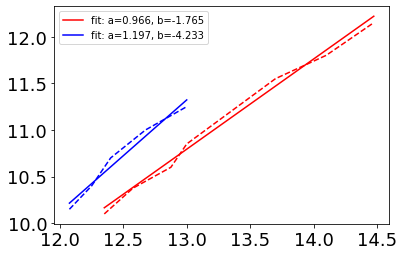

In [22]:
# linear fit for red/blue galaxies
def lfmsmh(x, a, b):
    return a*x +b
pored, pcred = curve_fit(lfmsmh,redgal[1,:],redgal[0,:])
plot(redgal[1,:],redgal[0,:],'r--')
# plot(redgal_hb[0,:],redgal_hb[1,:],'m--')
plot(redgal[1,:], lfmsmh(redgal[1,:], *pored), 'r-', label='fit: a=%5.3f, b=%5.3f' % tuple(pored))

poblu, pcblu = curve_fit(lfmsmh,blugal[1,:],blugal[0,:])
plot(blugal[1,:],blugal[0,:],'b--')
# plot(blugal_hb[0,:],blugal_hb[1,:],'g--')
plot(blugal[1,:], lfmsmh(blugal[1,:], *poblu), 'b-', label='fit: a=%5.3f, b=%5.3f' % tuple(poblu))

legend()

/home/weiguang/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/weiguang/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/weiguang/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/weiguang/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/weiguang/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/weiguang/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  

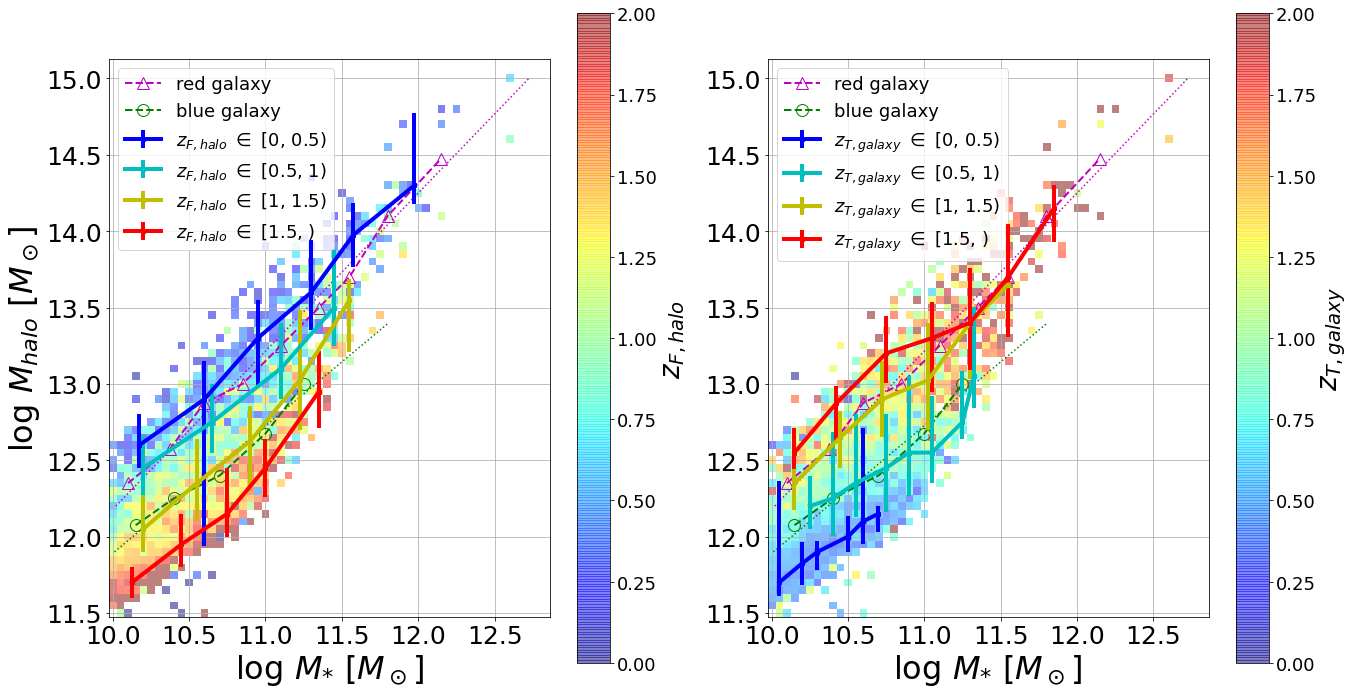

In [23]:
fig=figure(figsize=(19,10))
TmpFQ = FoQum100
idcutmass=idmc100

sxlim=[10,12.7]
sylim=[11.5,15.2]
mbs=0.05
ax0=subplot(122)

pmmden,xbe,ybe,bn=bst2(TmpFQ[idcutmass,2], TmpFQ[idcutmass,3], TmpFQ[idcutmass, 19], statistic='median', bins=[np.arange(10,12.7, mbs),np.arange(11.5,15.2, mbs)])
imshow(pmmden.T,origin='lower',cmap='jet',vmax=2,vmin=0,alpha=0.5)

xc,yc=np.mgrid[0:pmmden.shape[0],0:pmmden.shape[1]]
xc=xc.flatten(); yc=yc.flatten(); mreds=np.copy(pmmden.flatten())
for i,li,cc in zip([[0,0.5],[0.5,1],[1,1.5],[1.5,5]],['[0, 0.5)','[0.5, 1)','[1, 1.5)', '[1.5, )'],['b','c','y','r']):
    ids=(mreds>=i[0])&(mreds<i[1])
    mdr=np.median(mreds[ids])
    x=xc[ids]
    myp=yc[ids]
    nbn=9
    plmden,be,bn=bst(x, myp, statistic=lambda y: np.percentile(y, 16), bins=nbn)
    pumden,be,bn=bst(x, myp, statistic=lambda y: np.percentile(y, 84), bins=nbn)
    pmmden,bemden,bn=bst(x, myp, statistic=lambda y: np.percentile(y, 50), bins=nbn)
    bn,bemden,bn2=bst(x, myp, statistic='count', bins=nbn)
    xvd = np.zeros(bemden.size-1)
    for j in range(xvd.size):
        idinb=(x>=bemden[j])&(x<bemden[j+1])
        xvd[j] = np.median(x[idinb])
    idbn=bn>5
    if i[1]==0.5:
        idbn=bn>5
    if i[0]==0.5:
        idbn[0]=False
    if i[0]==1:
        idbn[1]=True
    errorbar(xvd[idbn], pmmden[idbn], yerr=np.append(pmmden-plmden,pumden-pmmden).reshape(2,plmden.size)[:,idbn],
             marker='s', color=cc, ls='-',lw=4,ms=4,zorder=99, label=r'$z_{T, galaxy}\ \in$ '+li)

# plot red and blue galaxies
plot((redgal[0,:]-sxlim[0])/mbs, (redgal[1,:]-sylim[0])/mbs, #xerr=np.append(redgal[2,:],redgal[3,:]).reshape(2,redgal[0,:].size),
             marker='^', color='m', ls='--',lw=2,ms=12,zorder=90, mfc='None', label=r'red galaxy')
plot((blugal[0,:]-sxlim[0])/mbs, (blugal[1,:]-sylim[0])/mbs, #xerr=np.append(blugal[2,:],blugal[3,:]).reshape(2,blugal[0,:].size),
             marker='o', color='g', ls='--',lw=2,ms=12,zorder=90, mfc='None', label=r'blue galaxy')

x=np.arange(11.9,13.5,0.1)
plot((1.197*x-4.233-sxlim[0])/mbs,(x-sylim[0])/mbs, 'g:')
x=np.arange(12.2,15,0.1)
plot((0.966*x-1.765-sxlim[0])/mbs,(x-sylim[0])/mbs, 'm:')

c1=colorbar()
c1.ax.set_ylabel('$z_{T, galaxy}$',fontsize=28)
xlabel(r'$\log\ M_{*} \ [M_\odot]$', fontsize=32)
xticks(fontsize=25)
yticks(fontsize=25)

ntkb=10
ax0.set_xticks(np.arange(0,xbe.shape[0]-1, ntkb, dtype=np.int32))
ax0.set_yticks(np.arange(0,ybe.shape[0]-1, ntkb, dtype=np.int32)) 
ax0.set_yticklabels(np.arange(sylim[0],sylim[1], ntkb*mbs))
ax0.set_xticklabels(np.arange(sxlim[0],sxlim[1], ntkb*mbs))
grid()
legend(loc=2,fontsize=18)

ax1=subplot(121)
pmmden,xbe,ybe,bn=bst2(TmpFQ[idcutmass,2], TmpFQ[idcutmass,3], TmpFQ[idcutmass, 22], statistic='median', bins=[np.arange(10,12.7, mbs), np.arange(11.5,15.2, mbs)])
imshow(pmmden.T,origin='lower',cmap='jet',aspect='equal',vmax=2,vmin=0,alpha=0.5)

xc,yc=np.mgrid[0:pmmden.shape[0],0:pmmden.shape[1]]
xc=xc.flatten(); yc=yc.flatten(); mreds=np.copy(pmmden.flatten())
for i,li,cc in zip([[0,0.5],[0.5,1],[1,1.5],[1.5,5]],['[0, 0.5)','[0.5, 1)','[1, 1.5)', '[1.5, )'],['b','c','y','r']):
    ids=(mreds>=i[0])&(mreds<i[1])
    mdr=np.median(mreds[ids])
    x=xc[ids]
    myp=yc[ids]
    nbn=6
    plmden,be,bn=bst(x, myp, statistic=lambda y: np.percentile(y, 16), bins=nbn)
    pumden,be,bn=bst(x, myp, statistic=lambda y: np.percentile(y, 84), bins=nbn)
    pmmden,bemden,bn=bst(x, myp, statistic=lambda y: np.percentile(y, 50), bins=nbn)
    bn,bemden,bn2=bst(x, myp, statistic='count', bins=nbn)
    xvd = np.zeros(bemden.size-1)
    for j in range(xvd.size):
        idinb=(x>=bemden[j])&(x<bemden[j+1])
        xvd[j] = np.median(x[idinb])
    if i[0]==0:
        idbn=bn>8
    else:
        idbn=bn>6
    errorbar(xvd[idbn], pmmden[idbn], yerr=np.append(pmmden-plmden,pumden-pmmden).reshape(2,plmden.size)[:,idbn],
             marker='s', color=cc, ls='-',lw=4,ms=4,zorder=99, label=r'$z_{F, halo}\ \in$ '+li) #matplotlib.cm.jet((mdr-0.1)/1.9)

# plot red and blue galaxies
plot((redgal[0,:]-sxlim[0])/mbs, (redgal[1,:]-sylim[0])/mbs, #yerr=np.append(redgal[2,:],redgal[3,:]).reshape(2,redgal[0,:].size),
             marker='^', color='m', ls='--',lw=2,ms=12,zorder=90, mfc='None', label=r'red galaxy')
plot((blugal[0,:]-sxlim[0])/mbs, (blugal[1,:]-sylim[0])/mbs, #yerr=np.append(blugal[2,:],blugal[3,:]).reshape(2,blugal[0,:].size),
             marker='o', color='g', ls='--',lw=2,ms=12,zorder=90, mfc='None', label=r'blue galaxy')

x=np.arange(11.9,13.5,0.1)
plot((1.197*x-4.233-sxlim[0])/mbs,(x-sylim[0])/mbs, 'g:')
x=np.arange(12.2,15,0.1)
plot((0.966*x-1.765-sxlim[0])/mbs,(x-sylim[0])/mbs, 'm:')

c2=colorbar()
c2.ax.set_ylabel('$z_{F, halo}$',fontsize=28)
ylabel(r'$\log\ M_{halo}\ [M_\odot]$', fontsize=32)
xlabel(r'$\log\ M_{*} \ [M_\odot]$', fontsize=32)
xticks(fontsize=25)
yticks(fontsize=25)

ntkb=10
ax1.set_xticks(np.arange(0,xbe.shape[0]-1, ntkb, dtype=np.int32))
ax1.set_yticks(np.arange(0,ybe.shape[0]-1, ntkb, dtype=np.int32)) 
ax1.set_yticklabels(np.arange(sylim[0],sylim[1], ntkb*mbs))
ax1.set_xticklabels(np.arange(sxlim[0],sxlim[1], ntkb*mbs))

legend(loc=2,fontsize=18)
grid()
tight_layout()
savefig('plots/Fig2.pdf',dpi=300)

# Figure 8 -- inverse problem

/home/weiguang/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/weiguang/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-24-593fd91c0a64>:107: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dvi" which is no longer supported as of 3.3 and will become an error two minor releases later
  savefig('plots/S_inverse.pdf',dvi=300)


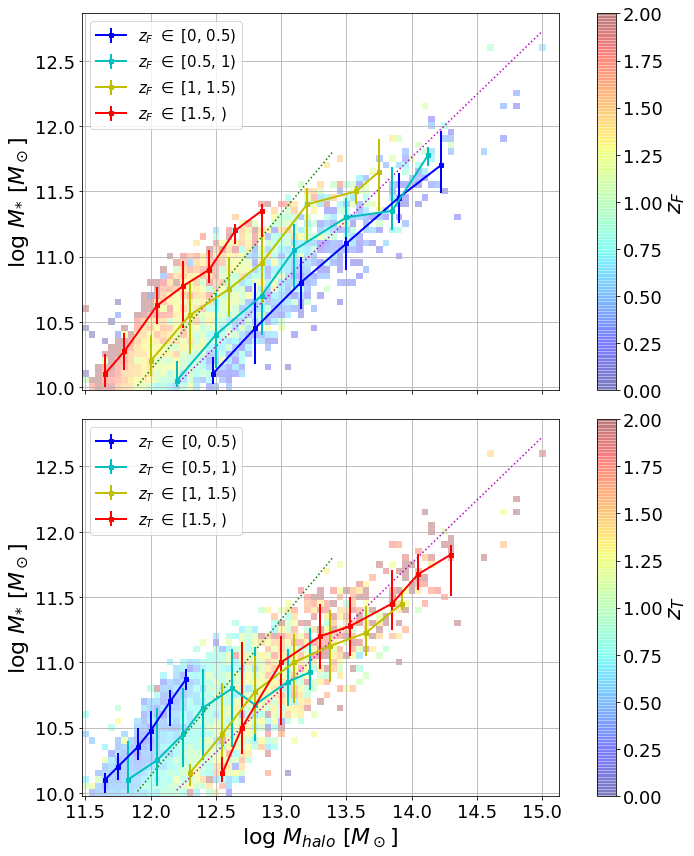

In [24]:
fig=figure(figsize=(11,12))
TmpFQ = FoQum100
idcutmass=idmc100

sylim=[10,12.7]
sxlim=[11.5,15.2]
mbs=0.05
ax0=subplot(212)

pmmden,xbe,ybe,bn=bst2(TmpFQ[idcutmass,3], TmpFQ[idcutmass,2], TmpFQ[idcutmass, 19], statistic='median', 
                       bins=[np.arange(sxlim[0],sxlim[1], mbs),np.arange(sylim[0],sylim[1], mbs)])
imshow(pmmden.T,origin='lower',cmap='jet',vmax=2,vmin=0,alpha=0.3)


xc,yc=np.mgrid[0:pmmden.shape[0],0:pmmden.shape[1]]
xc=xc.flatten(); yc=yc.flatten(); mreds=np.copy(pmmden.flatten())
mhinb=np.copy(xc*0.05+sxlim[0]); mginb=np.copy(yc*0.05+sylim[0]); mCinb=np.copy(mreds);
for i,li,cc in zip([[0,0.5],[0.5,1],[1,1.5],[1.5,5]],['[0, 0.5)','[0.5, 1)','[1, 1.5)', '[1.5, )'],['b','c','y','r']):
    ids=(mreds>=i[0])&(mreds<i[1])
    mdr=np.median(mreds[ids])
    x=xc[ids]
    myp=yc[ids]
    nbn=11
    plmden,be,bn=bst(x, myp, statistic=lambda y: np.percentile(y, 16), bins=nbn)
    pumden,be,bn=bst(x, myp, statistic=lambda y: np.percentile(y, 84), bins=nbn)
    pmmden,bemden,bn=bst(x, myp, statistic=lambda y: np.percentile(y, 50), bins=nbn)
    bn,bemden,bn2=bst(x, myp, statistic='count', bins=nbn)
    xvd = np.zeros(bemden.size-1)
    for j in range(xvd.size):
        idinb=(x>=bemden[j])&(x<bemden[j+1])
        xvd[j] = np.median(x[idinb])
    idbn=bn>5
    if i[0]==0.5:
        idbn[0]=False
    if i[0]==1.5:
        idbn[1]=True
    errorbar(xvd[idbn], pmmden[idbn], yerr=np.append(pmmden-plmden,pumden-pmmden).reshape(2,plmden.size)[:,idbn],
             marker='s', color=cc, ls='-',lw=2,ms=4,zorder=99, label=r'$z_{T}\ \in$ '+li)

# plot red and blue galaxies
x=np.arange(11.9,13.5,0.1)
plot((x-sxlim[0])/mbs, (1.197*x-4.233-sylim[0])/mbs,'g:')
x=np.arange(12.2,15,0.1)
plot((x-sxlim[0])/mbs, (0.966*x-1.765-sylim[0])/mbs,'m:')

c1=colorbar()
c1.ax.set_ylabel('$z_{T}$',fontsize=22)
xlabel(r'$\log\ M_{halo}\ [M_\odot]$', fontsize=22)
ylabel(r'$\log\ M_{*} \ [M_\odot]$', fontsize=22)

ntkb=10
ax0.set_xticks(np.arange(0,xbe.shape[0]-1, ntkb, dtype=np.int32))
ax0.set_yticks(np.arange(0,ybe.shape[0]-1, ntkb, dtype=np.int32)) 
ax0.set_yticklabels(np.arange(sylim[0],sylim[1], ntkb*mbs))
ax0.set_xticklabels(np.arange(sxlim[0],sxlim[1], ntkb*mbs))
grid()
legend(loc=2,fontsize=15)

ax1=subplot(211)
pmmden,xbe,ybe,bn=bst2(TmpFQ[idcutmass,3], TmpFQ[idcutmass,2], TmpFQ[idcutmass, 22], statistic='median', 
                       bins=[np.arange(sxlim[0],sxlim[1], mbs),np.arange(sylim[0],sylim[1], mbs)])
imshow(pmmden.T,origin='lower',cmap='jet',aspect='equal',vmax=2,vmin=0,alpha=0.3)

xc,yc=np.mgrid[0:pmmden.shape[0],0:pmmden.shape[1]]
xc=xc.flatten(); yc=yc.flatten(); mreds=np.copy(pmmden.flatten())
mhinbh=np.copy(xc*0.05+sxlim[0]); mginbh=np.copy(yc*0.05+sylim[0]); mFinb=np.copy(mreds);
for i,li,cc in zip([[0,0.5],[0.5,1],[1,1.5],[1.5,5]],['[0, 0.5)','[0.5, 1)','[1, 1.5)', '[1.5, )'],['b','c','y','r']):
    ids=(mreds>=i[0])&(mreds<i[1])
    mdr=np.median(mreds[ids])
    x=xc[ids]
    myp=yc[ids]
    nbn=9
    plmden,be,bn=bst(x, myp, statistic=lambda y: np.percentile(y, 16), bins=nbn)
    pumden,be,bn=bst(x, myp, statistic=lambda y: np.percentile(y, 84), bins=nbn)
    pmmden,bemden,bn=bst(x, myp, statistic=lambda y: np.percentile(y, 50), bins=nbn)
    bn,bemden,bn2=bst(x, myp, statistic='count', bins=nbn)
    xvd = np.zeros(bemden.size-1)
    for j in range(xvd.size):
        idinb=(x>=bemden[j])&(x<bemden[j+1])
        xvd[j] = np.median(x[idinb])
    idbn=bn>5
    if i[0]==0:
        idbn[0]=False

    errorbar(xvd[idbn], pmmden[idbn], yerr=np.append(pmmden-plmden,pumden-pmmden).reshape(2,plmden.size)[:,idbn],
             marker='s', color=cc, ls='-',lw=2,ms=4,zorder=99, label=r'$z_{F}\ \in$ '+li) #matplotlib.cm.jet((mdr-0.1)/1.9)

# plot red and blue galaxies
x=np.arange(11.9,13.5,0.1)
plot((x-sxlim[0])/mbs, (1.197*x-4.233-sylim[0])/mbs,'g:')
x=np.arange(12.2,15,0.1)
plot((x-sxlim[0])/mbs, (0.966*x-1.765-sylim[0])/mbs,'m:')

c2=colorbar()
c2.ax.set_ylabel('$z_{F}$',fontsize=22)
ylabel(r'$\log\ M_{*} \ [M_\odot]$', fontsize=22)

ntkb=10
ax1.set_xticks(np.arange(0,xbe.shape[0]-1, ntkb, dtype=np.int32))
ax1.set_yticks(np.arange(0,ybe.shape[0]-1, ntkb, dtype=np.int32)) 
ax1.set_yticklabels(np.arange(sylim[0],sylim[1], ntkb*mbs))
ax1.set_xticklabels(np.repeat('', np.int(np.ceil((xbe.shape[0]-1)/ntkb))))

legend(loc=2,fontsize=15)
grid()
tight_layout()
savefig('plots/S_inverse.pdf',dvi=300)

# Fig. 3 Evolution track

In [25]:
# Now calc the median evolution lines
mhbs=[11.5,11.9, 12.2,12.5,12.8,13.1,13.4,15.1]
logms = np.log10(track_cm100n1024.stellarmasses[0,idmc100])
logmh = np.log10(track_cm100n1024.halomasses_fof[0,idmc100])

ideq=(logmh*0.966-1.765)>logms
idmq=((logmh*0.966-1.765)<=logms)&((logmh*1.197-4.233)>logms)
idlq=(logmh*1.197-4.233)<logms

eqidinb={}
mqidinb={}
lqidinb={}
for i,mh in enumerate(mhbs[:-1]):
    tid=(logmh[ideq]>mh)&(logmh[ideq]<=mhbs[i+1])
    if len(logmh[ideq][tid])>30:
        eqidinb[str(mh)]=np.copy(tid)
    else:
        eqidinb[str(mh)]=None
        
    tid=(logmh[idmq]>mh)&(logmh[idmq]<=mhbs[i+1])
    if len(logmh[idmq][tid])>30:
        mqidinb[str(mh)]=np.copy(tid)
    else:
        mqidinb[str(mh)]=None
        
    tid=(logmh[idlq]>mh)&(logmh[idlq]<=mhbs[i+1])
    if len(logmh[idlq][tid])>30:
        lqidinb[str(mh)]=np.copy(tid)
    else:
        lqidinb[str(mh)]=None   
        
for i,mh in enumerate(mhbs[:-1]):
    
    if eqidinb[str(mh)] is not None:
        sm=track_cm100n1024.stellarmasses[:,idmc100].T[ideq][eqidinb[str(mh)]]
        mediansm = np.percentile(sm, 50, axis=0)[::-1]
        hm=track_cm100n1024.halomasses_fof[:,idmc100].T[ideq][eqidinb[str(mh)]]
        medianhm = np.percentile(hm, 50, axis=0)[::-1]
        him=track_cm100n1024.HImasses[:,idmc100].T[ideq][eqidinb[str(mh)]]
        medianhim = np.percentile(him, 50, axis=0)[::-1]
        h2m=track_cm100n1024.H2masses[:,idmc100].T[ideq][eqidinb[str(mh)]]
        medianh2m = np.percentile(h2m, 50, axis=0)[::-1]
        bhm=track_cm100n1024.bhmasses[:,idmc100].T[ideq][eqidinb[str(mh)]]
        medianbhm = np.percentile(bhm, 50, axis=0)[::-1]
        
        idbn=(mediansm>10**6) & (medianhm>10**6)
        eqidinb[str(mh)+'_uage']=uni_a[idbn]
        eqidinb[str(mh)+'_reds']=reds[idbn]
        eqidinb[str(mh)+'_sc_a']=sc_a[idbn]
        eqidinb[str(mh)+'_sm'] = mediansm[idbn]
        eqidinb[str(mh)+'_hm'] = medianhm[idbn]
        eqidinb[str(mh)+'_him'] = medianhim[idbn]
        eqidinb[str(mh)+'_h2m'] = medianh2m[idbn] 
        eqidinb[str(mh)+'_bhm'] = medianbhm[idbn]
        
        eqidinb[str(mh)+'_hft'] = np.percentile(FoQum100[idmc100, 16][ideq][eqidinb[str(mh)]], 50) #halo formation time Gyr
        eqidinb[str(mh)+'_sft'] = np.percentile(FoQum100[idmc100, 12][ideq][eqidinb[str(mh)]], 50) #galaxy qt time Gyr
        eqidinb[str(mh)+'_bht'] = np.percentile(FoQum100[idmc100, 11][ideq][eqidinb[str(mh)]], 50) #BH jet time Gyr
        
        eqidinb[str(mh)+'_hm_hft'] = np.interp(eqidinb[str(mh)+'_hft'], uni_a, medianhm)  #halo mass at halo ft
        eqidinb[str(mh)+'_sm_hft'] = np.interp(eqidinb[str(mh)+'_hft'], uni_a, mediansm)  #galaxy mass at halo ft
        eqidinb[str(mh)+'_hm_sft'] = np.interp(eqidinb[str(mh)+'_sft'], uni_a, medianhm) # halo mass at galaxy ft
        eqidinb[str(mh)+'_sm_sft'] = np.interp(eqidinb[str(mh)+'_sft'], uni_a, mediansm) # galaxy mass at galaxy ft
        eqidinb[str(mh)+'_bhm_bht'] = np.interp(eqidinb[str(mh)+'_bht'], uni_a, medianbhm) # galaxy mass at galaxy ft
        
    if mqidinb[str(mh)] is not None:
        sm=track_cm100n1024.stellarmasses[:,idmc100].T[idmq][mqidinb[str(mh)]]
        mediansm = np.percentile(sm, 50, axis=0)[::-1]
        hm=track_cm100n1024.halomasses_fof[:,idmc100].T[idmq][mqidinb[str(mh)]]
        medianhm = np.percentile(hm, 50, axis=0)[::-1]
        him=track_cm100n1024.HImasses[:,idmc100].T[idmq][mqidinb[str(mh)]]
        medianhim = np.percentile(him, 50, axis=0)[::-1]
        h2m=track_cm100n1024.H2masses[:,idmc100].T[idmq][mqidinb[str(mh)]]
        medianh2m = np.percentile(h2m, 50, axis=0)[::-1]
        bhm=track_cm100n1024.bhmasses[:,idmc100].T[idmq][mqidinb[str(mh)]]
        medianbhm = np.percentile(bhm, 50, axis=0)[::-1]
        
        idbn=(mediansm>10**6) & (medianhm>10**6)
        mqidinb[str(mh)+'_uage']=uni_a[idbn]
        mqidinb[str(mh)+'_reds']=reds[idbn]
        mqidinb[str(mh)+'_sc_a']=sc_a[idbn]
        mqidinb[str(mh)+'_sm'] = mediansm[idbn]
        mqidinb[str(mh)+'_hm'] = medianhm[idbn]
        mqidinb[str(mh)+'_him'] = medianhim[idbn]
        mqidinb[str(mh)+'_h2m'] = medianh2m[idbn]
        mqidinb[str(mh)+'_bhm'] = medianbhm[idbn]
        
        mqidinb[str(mh)+'_hft'] = np.percentile(FoQum100[idmc100, 16][idmq][mqidinb[str(mh)]], 50)
        mqidinb[str(mh)+'_sft'] = np.percentile(FoQum100[idmc100, 12][idmq][mqidinb[str(mh)]], 50)
        mqidinb[str(mh)+'_bht'] = np.percentile(FoQum100[idmc100, 11][idmq][mqidinb[str(mh)]], 50) #BH jet time Gyr
        
        mqidinb[str(mh)+'_hm_hft'] = np.interp(mqidinb[str(mh)+'_hft'], uni_a, medianhm)  #halo mass at halo ft
        mqidinb[str(mh)+'_sm_hft'] = np.interp(mqidinb[str(mh)+'_hft'], uni_a, mediansm)  #galaxy mass at halo ft
        mqidinb[str(mh)+'_hm_sft'] = np.interp(mqidinb[str(mh)+'_sft'], uni_a, medianhm) # halo mass at galaxy ft
        mqidinb[str(mh)+'_sm_sft'] = np.interp(mqidinb[str(mh)+'_sft'], uni_a, mediansm) # galaxy mass at galaxy ft
        mqidinb[str(mh)+'_bhm_bht'] = np.interp(mqidinb[str(mh)+'_bht'], uni_a, medianbhm) # bh mass at bh jt
        
    if lqidinb[str(mh)] is not None:
        sm=track_cm100n1024.stellarmasses[:,idmc100].T[idlq][lqidinb[str(mh)]]
        mediansm = np.percentile(sm, 50, axis=0)[::-1]
        hm=track_cm100n1024.halomasses_fof[:,idmc100].T[idlq][lqidinb[str(mh)]]
        medianhm = np.percentile(hm, 50, axis=0)[::-1]
        him=track_cm100n1024.HImasses[:,idmc100].T[idlq][lqidinb[str(mh)]]
        medianhim = np.percentile(him, 50, axis=0)[::-1]
        h2m=track_cm100n1024.H2masses[:,idmc100].T[idlq][lqidinb[str(mh)]]
        medianh2m = np.percentile(h2m, 50, axis=0)[::-1]
        bhm=track_cm100n1024.bhmasses[:,idmc100].T[idlq][lqidinb[str(mh)]]
        medianbhm = np.percentile(bhm, 50, axis=0)[::-1]
        
        idbn=(mediansm>10**6) & (medianhm>10**6)
        lqidinb[str(mh)+'_uage']=uni_a[idbn]
        lqidinb[str(mh)+'_reds']=reds[idbn]
        lqidinb[str(mh)+'_sc_a']=sc_a[idbn]
        lqidinb[str(mh)+'_sm'] = mediansm[idbn]
        lqidinb[str(mh)+'_hm'] = medianhm[idbn]
        lqidinb[str(mh)+'_him'] = medianhim[idbn]
        lqidinb[str(mh)+'_h2m'] = medianh2m[idbn]
        lqidinb[str(mh)+'_bhm'] = medianbhm[idbn]
        
        lqidinb[str(mh)+'_hft'] = np.percentile(FoQum100[idmc100, 16][idlq][lqidinb[str(mh)]], 50)
        lqidinb[str(mh)+'_sft'] = np.percentile(FoQum100[idmc100, 12][idlq][lqidinb[str(mh)]], 50)
        lqidinb[str(mh)+'_bht'] = np.percentile(FoQum100[idmc100, 11][idlq][lqidinb[str(mh)]], 50) #BH jet time Gyr
        
        lqidinb[str(mh)+'_hm_hft'] = np.interp(lqidinb[str(mh)+'_hft'], uni_a, medianhm)  #halo mass at halo ft
        lqidinb[str(mh)+'_sm_hft'] = np.interp(lqidinb[str(mh)+'_hft'], uni_a, mediansm)  #galaxy mass at halo ft
        lqidinb[str(mh)+'_hm_sft'] = np.interp(lqidinb[str(mh)+'_sft'], uni_a, medianhm) # halo mass at galaxy ft
        lqidinb[str(mh)+'_sm_sft'] = np.interp(lqidinb[str(mh)+'_sft'], uni_a, mediansm) # galaxy mass at galaxy ft
        lqidinb[str(mh)+'_bhm_bht'] = np.interp(lqidinb[str(mh)+'_bht'], uni_a, medianbhm) # bh mass at bh jt

In [26]:
from matplotlib.collections import LineCollection

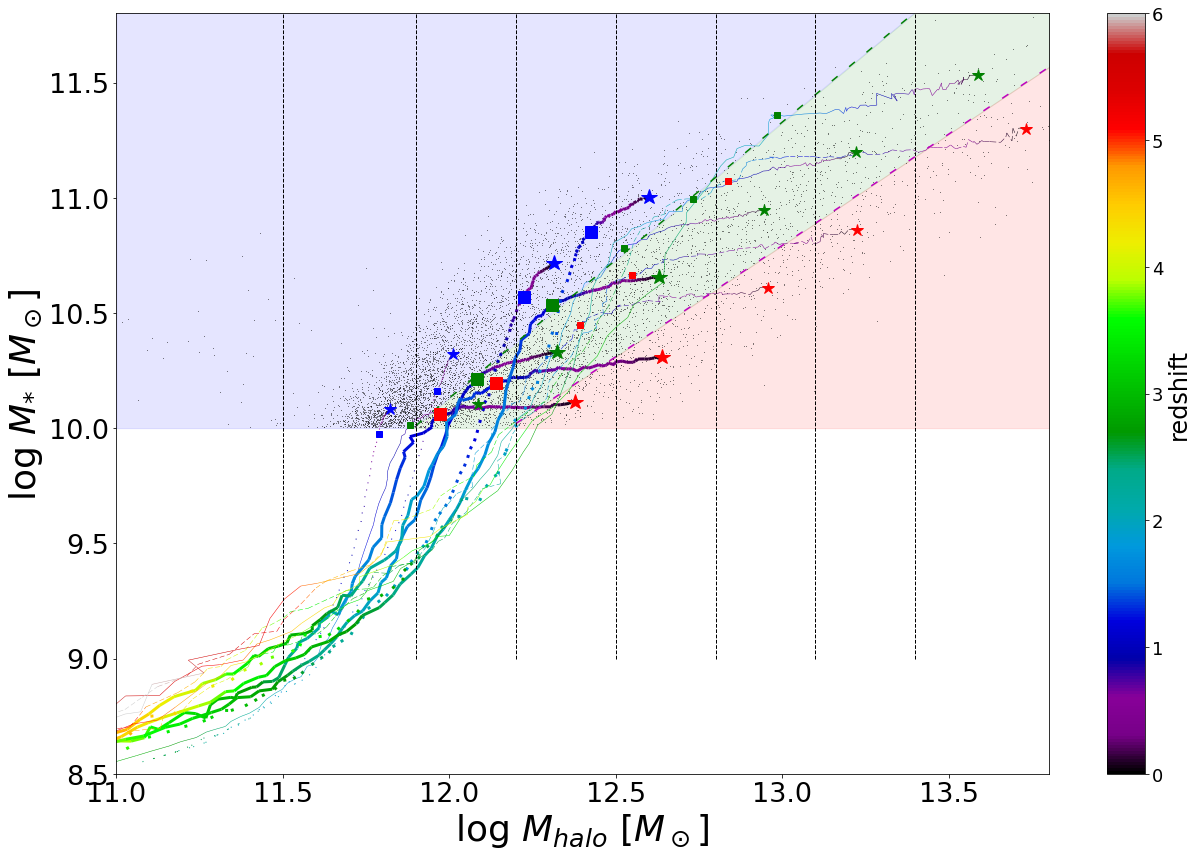

In [27]:
#plot M* vs Mh

fig=figure(figsize=(18,12))
ax=subplot(111)
logms = np.log10(track_cm100n1024.stellarmasses[0,idmc100])
logmh = np.log10(track_cm100n1024.halomasses_fof[0,idmc100])

x=np.arange(11.9,13.5,0.1)
plot(x, (1.197*x-4.233),'g',ls=(0,(5,10)))
x=np.arange(12.2,15,0.1)
plot(x, (0.966*x-1.765),'m',ls=(0,(5,10)))

fill_between([11,11.89, 14],[12,12,12],[10,10,12.525],color="b",alpha=0.1,zorder=-9)
fill_between([11.89,12.179,14],[10,10.34,12.525],[10,10,11.759],color="g",alpha=0.1,zorder=-9)
fill_between([12.179,14],[10,11.759],[10,10],color="r",alpha=0.1,zorder=-9)

mhbs=[11.5,11.9, 12.2,12.5,12.8,13.1,13.4,15.1]
lstys=[':','--','-','-.',(0, (2,5)),(0,(8,10)),(0,(8,10,2,5))]

for i,mh in enumerate(mhbs[:-1]):
    plot([mh,mh],[9,12.6],'k--',lw=1)
    
    if eqidinb[str(mh)] is not None:
        points = np.array([np.log10(eqidinb[str(mh)+'_hm']),np.log10(eqidinb[str(mh)+'_sm'])]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        norm = plt.Normalize(0, 6)
        lc = LineCollection(segments, cmap='nipy_spectral', norm=norm)
        # Set the values used for colormapping
        lc.set_array(eqidinb[str(mh)+'_reds'])
        if (mh == 12.2) or (mh == 12.5):
            lc.set_linewidth(3)
            plot(np.log10(eqidinb[str(mh)+'_hm_sft']),np.log10(eqidinb[str(mh)+'_sm_sft']),'rs',ms=12) # quenching time
        else:
            lc.set_linewidth(0.5)
            plot(np.log10(eqidinb[str(mh)+'_hm_sft']),np.log10(eqidinb[str(mh)+'_sm_sft']),'rs',ms=6) # quenching time
        lc.set_linestyle((0,(10,5)))
        line = ax.add_collection(lc)
        
        
    if mqidinb[str(mh)] is not None:
        points = np.array([np.log10(mqidinb[str(mh)+'_hm']),np.log10(mqidinb[str(mh)+'_sm'])]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        norm = plt.Normalize(0, 6)
        lc = LineCollection(segments, cmap='nipy_spectral', norm=norm)
        # Set the values used for colormapping
        lc.set_array(mqidinb[str(mh)+'_reds'])
        if (mh == 12.2) or (mh == 12.5):
            lc.set_linewidth(3)
            plot(np.log10(mqidinb[str(mh)+'_hm_sft']),np.log10(mqidinb[str(mh)+'_sm_sft']),'gs',ms=12)
        else:
            lc.set_linewidth(0.5)
            plot(np.log10(mqidinb[str(mh)+'_hm_sft']),np.log10(mqidinb[str(mh)+'_sm_sft']),'gs',ms=6)
        lc.set_linestyle('-')
        line = ax.add_collection(lc)
                
    if lqidinb[str(mh)] is not None:
        points = np.array([np.log10(lqidinb[str(mh)+'_hm']),np.log10(lqidinb[str(mh)+'_sm'])]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        norm = plt.Normalize(0, 6)
        lc = LineCollection(segments, cmap='nipy_spectral', norm=norm)
        # Set the values used for colormapping
        lc.set_array(lqidinb[str(mh)+'_reds'])
        if (mh == 12.2) or (mh == 12.5):
            lc.set_linewidth(3)
            plot(np.log10(lqidinb[str(mh)+'_hm_sft']),np.log10(lqidinb[str(mh)+'_sm_sft']),'bs',ms=12)
        else:
            lc.set_linewidth(1)
            plot(np.log10(lqidinb[str(mh)+'_hm_sft']),np.log10(lqidinb[str(mh)+'_sm_sft']),'bs',ms=6)
        lc.set_linestyle((0,(1,10)))
        line = ax.add_collection(lc)
           
c3=colorbar(line)
c3.ax.set_ylabel('redshift',fontsize=24)
for sid,sc in zip([ideq,idmq,idlq],['r','g','b']):
    x=logmh[sid]
    myp=logms[sid]
    plot(logmh[sid], logms[sid],'k,',alpha=0.5,zorder=-3)
    pmmden,bemden,bn=bst(x, myp, statistic=lambda y: np.percentile(y, 50), bins=mhbs)
    hmmden,bemden,bn=bst(x, x, statistic=lambda y: np.percentile(y, 50), bins=mhbs)
    bn,bemden,bn2=bst(x, myp, statistic='count', bins=mhbs)
    ids=bn>30
    plot(hmmden[ids],pmmden[ids],'*',ms=12,color=sc,zorder=9)
    idins=(hmmden[ids]>12.2)&(hmmden[ids]<12.8)
    plot(hmmden[ids][idins],pmmden[ids][idins],'*',ms=16,color=sc,zorder=10)

xlim(11.,13.8)
ylim(8.5,11.8)
xlabel(r'$\log\ M_{halo}\ [M_\odot]$', fontsize=36)
ylabel(r'$\log\ M_{*} \ [M_\odot]$', fontsize=36)
xticks(fontsize=27)
yticks(fontsize=27)
tight_layout()
savefig('plots/Fig3.pdf',dpi=300)

# Fig. 4 Time correlations

/home/weiguang/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/weiguang/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/weiguang/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/weiguang/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


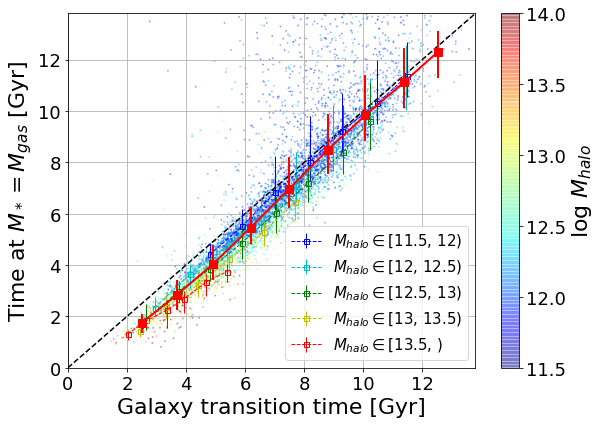

In [28]:
fig=figure(figsize=(8.5,6))

TmpFQ = FoQum100
idcutmass=idmc100

# subplot(121)
scatter(TmpFQ[idcutmass, 12], TmpFQ[idcutmass,26], s=1,c=TmpFQ[idcutmass,3],cmap='jet',vmax=14,vmin=11.5,rasterized=True, alpha=0.3)

ids=(TmpFQ[idcutmass, 12]<=13.8)&(TmpFQ[idcutmass,26]<13.8)
x=TmpFQ[idcutmass,12][ids]
myp=TmpFQ[idcutmass,26][ids]
nbn=9
plmden,be,bn=bst(x, myp, statistic=lambda y: np.percentile(y, 16), bins=nbn)
pumden,be,bn=bst(x, myp, statistic=lambda y: np.percentile(y, 84), bins=nbn)
pmmden,bemden,bn=bst(x, myp, statistic=lambda y: np.percentile(y, 50), bins=nbn)
bn,bemden,bn2=bst(x, myp, statistic='count', bins=nbn)
xvd = np.zeros(bemden.size-1)
for j in range(xvd.size):
    idinb=(x>=bemden[j])&(x<bemden[j+1])
    xvd[j] = np.median(x[idinb])
idbn=bn>6
errorbar(xvd[idbn], pmmden[idbn], yerr=np.append(pmmden-plmden,pumden-pmmden).reshape(2,plmden.size)[:,idbn],
         marker='s', color='r', ls='-',lw=2,ms=8,zorder=99)

#separated in halo mass
for i,li,cc in zip([[11.5,12],[12,12.5],[12.5,13],[13,13.5],[13.5,16]],['[11.5, 12)','[12, 12.5)','[12.5, 13)','[13, 13.5)', '[13.5, )'],['b','c','g','y','r']):
    ids=(TmpFQ[idcutmass,3]>i[0])&(TmpFQ[idcutmass,3]<=i[1])&(TmpFQ[idcutmass, 12]<13.8)&(TmpFQ[idcutmass,26]<13.8)

    x=TmpFQ[idcutmass,12][ids]
    myp=TmpFQ[idcutmass,26][ids]

    plmden,be,bn=bst(x, myp, statistic=lambda y: np.percentile(y, 16), bins=nbn)
    pumden,be,bn=bst(x, myp, statistic=lambda y: np.percentile(y, 84), bins=nbn)
    pmmden,bemden,bn=bst(x, myp, statistic=lambda y: np.percentile(y, 50), bins=nbn)
    bn,bemden,bn2=bst(x, myp, statistic='count', bins=nbn)
    xvd = np.zeros(bemden.size-1)
    for j in range(xvd.size):
        idinb=(x>=bemden[j])&(x<bemden[j+1])
        xvd[j] = np.median(x[idinb])
    idbn=bn>15
    if i[0]==13.5:
        idbn=bn>10
    errorbar(xvd[idbn], pmmden[idbn], yerr=np.append(pmmden-plmden,pumden-pmmden).reshape(2,plmden.size)[:,idbn],
         marker='s', color=cc, ls='--', lw=1, ms=5, mfc='none', zorder=90, label=r'$M_{halo}\in$'+li)

c1=colorbar()
c1.ax.set_ylabel('$\log\ M_{halo}$',fontsize=22)
grid()
legend(fontsize=15)
plot([0,13.99],[0,13.99],'k--')
xlim(0,13.8);ylim(0,13.8)
xlabel('Galaxy transition time [Gyr]', fontsize=22)
ylabel('Time at $M_* = M_{gas}$ [Gyr]', fontsize=22)


tight_layout()
savefig('plots/Fig4_1.pdf',dpi=300)

[  6.  45. 177. 329. 400. 402. 200.  51.   6.]
[ 27. 201. 491. 636. 548. 362. 150.  43.   5.]
[ 42. 133. 228. 234. 157. 117.  61.  30.   4.]
[ 8. 49. 85. 85. 78. 50. 25. 11.  8.]
[10. 21. 37. 30. 21. 11.  9.  2.  1.]


/home/weiguang/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/weiguang/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


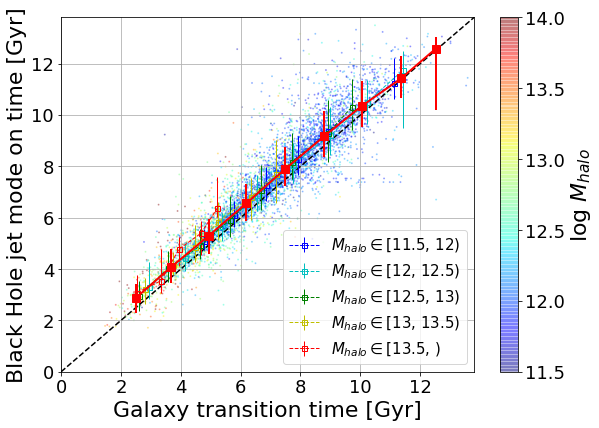

In [29]:
fig=figure(figsize=(8.5,6))
idcutmass=idmc100
scatter(TmpFQ[idcutmass, 12], TmpFQ[idcutmass,11], s=1,c=TmpFQ[idcutmass,3],cmap='jet',vmax=14,vmin=11.5,rasterized=True, alpha=0.3)

ids=(TmpFQ[idcutmass, 12]<=13.8)&(TmpFQ[idcutmass,11]<13.8)
x=TmpFQ[idcutmass,12][ids]
myp=TmpFQ[idcutmass,11][ids]
nbn=9
plmden,be,bn=bst(x, myp, statistic=lambda y: np.percentile(y, 16), bins=nbn)
pumden,be,bn=bst(x, myp, statistic=lambda y: np.percentile(y, 84), bins=nbn)
pmmden,bemden,bn=bst(x, myp, statistic=lambda y: np.percentile(y, 50), bins=nbn)
bn,bemden,bn2=bst(x, myp, statistic='count', bins=nbn)
xvd = np.zeros(bemden.size-1)
for j in range(xvd.size):
    idinb=(x>=bemden[j])&(x<bemden[j+1])
    xvd[j] = np.median(x[idinb])
idbn=bn>6
errorbar(xvd[idbn], pmmden[idbn], yerr=np.append(pmmden-plmden,pumden-pmmden).reshape(2,plmden.size)[:,idbn],
         marker='s', color='r', ls='-',lw=2,ms=8,zorder=99)
#separated in halo mass
for i,li,cc in zip([[11.5,12],[12,12.5],[12.5,13],[13,13.5],[13.5,16]],['[11.5, 12)','[12, 12.5)','[12.5, 13)','[13, 13.5)', '[13.5, )'],['b','c','g','y','r']):
    ids=(TmpFQ[idcutmass,3]>i[0])&(TmpFQ[idcutmass,3]<=i[1])&(TmpFQ[idcutmass, 12]<13.8)&(TmpFQ[idcutmass,11]<13.8)

    x=TmpFQ[idcutmass,12][ids]
    myp=TmpFQ[idcutmass,11][ids]

    plmden,be,bn=bst(x, myp, statistic=lambda y: np.percentile(y, 16), bins=nbn)
    pumden,be,bn=bst(x, myp, statistic=lambda y: np.percentile(y, 84), bins=nbn)
    pmmden,bemden,bn=bst(x, myp, statistic=lambda y: np.percentile(y, 50), bins=nbn)
    bn,bemden,bn2=bst(x, myp, statistic='count', bins=nbn)
    print(bn)
    xvd = np.zeros(bemden.size-1)
    for j in range(xvd.size):
        idinb=(x>=bemden[j])&(x<bemden[j+1])
        xvd[j] = np.median(x[idinb])
    idbn=bn>15
    if i[0]==13.5:
        idbn=bn>10
    errorbar(xvd[idbn], pmmden[idbn], yerr=np.append(pmmden-plmden,pumden-pmmden).reshape(2,plmden.size)[:,idbn],
         marker='s', color=cc, ls='--', lw=1, ms=5, mfc='none', zorder=90, label=r'$M_{halo}\in$'+li)

c1=colorbar()
c1.ax.set_ylabel('$\log\ M_{halo}$',fontsize=22)
plot([0,13.99],[0,13.99],'k--')
xlim(0,13.8);ylim(0,13.8)
grid()
legend(fontsize=15)

xlabel('Galaxy transition time [Gyr]', fontsize=22)
ylabel('Black Hole jet mode on time [Gyr]', fontsize=22)

tight_layout()
savefig('plots/Fig4_2.pdf',dpi=300)

# Fig. 5 Gas fraction difference before quenching

In [30]:
#functions for second axis
def age2red(x):
    if len(x) >0:
        rearr=np.copy(x)
        rearr[x<0.0006]=1.0e3
        rearr[x>13.863]=0
        ids=np.where((x>0.0006)&(x<13.863))[0]
        for i in ids:
            rearr[i]=z_at_value(cosm.age, x[i] * u.Gyr)
        return rearr
    else:
        return z_at_value(cosm.age, x * u.Gyr)
def red2age(x):
    return cosm.age(x).value

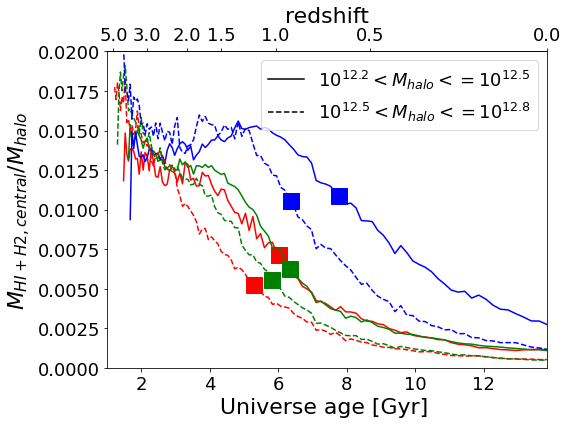

In [31]:
fig=figure(figsize=(8,6))
ax=subplot(111)

for mh,lss in zip([12.2, 12.5],['-','--']):

    for data,c in zip([eqidinb,mqidinb,lqidinb],['r','g','b']):
        gf=(data[str(mh)+'_him']+data[str(mh)+'_h2m'])/data[str(mh)+'_hm']
        plot(data[str(mh)+'_uage'], gf, ls=lss,color=c)
        gft=np.interp(data[str(mh)+'_sft'], data[str(mh)+'_uage'], gf)  #gas fraction at qt
        plot(data[str(mh)+'_sft'],gft,marker='s',color=c,ms=16) # quenching time

plot([],[],'k-',label='$10^{12.2} < M_{halo} <= 10^{12.5}$')
plot([],[],'k--',label='$10^{12.5} < M_{halo} <= 10^{12.8}$')
legend(fontsize=18)
secaxy = ax.secondary_xaxis('top', functions=(age2red, red2age))
secaxy.set_xlabel(r'redshift',fontsize=22)
secaxy.set_xticks([0,0.5,1,1.5,2,3,5])
xlim(1,uniage)
ylim(0,0.02)
xlabel(r'Universe age [Gyr] ',fontsize=22)
ylabel(r'$M_{HI+H2, central}/M_{halo}$',fontsize=22)
tight_layout()
savefig('plots/Fig5.pdf',dpi=300)

# supplyment

## methods

<ipython-input-32-152be67dc549>:15: RuntimeWarning: divide by zero encountered in log10
  plot(data[str(mh)+'_uage'],np.log10(data[str(mh)+'_bhm']),ls='--',lw=2,color=c)
<ipython-input-32-152be67dc549>:15: RuntimeWarning: divide by zero encountered in log10
  plot(data[str(mh)+'_uage'],np.log10(data[str(mh)+'_bhm']),ls='--',lw=2,color=c)
<ipython-input-32-152be67dc549>:15: RuntimeWarning: divide by zero encountered in log10
  plot(data[str(mh)+'_uage'],np.log10(data[str(mh)+'_bhm']),ls='--',lw=2,color=c)
<ipython-input-32-152be67dc549>:43: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  tight_layout()


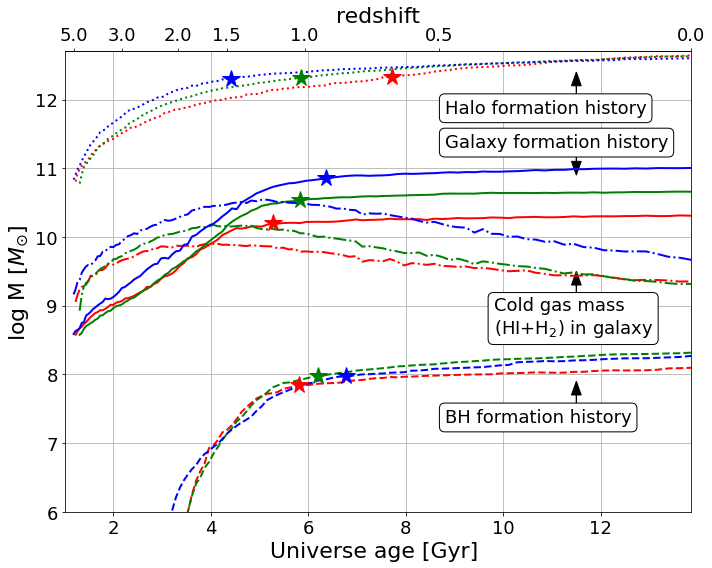

In [32]:
fig, ax = subplots(constrained_layout=True,figsize=(10,8))

lls=['-','--',':','-.']
clr=['r','b','g']
n=1

mh=12.5
for data,c in zip([eqidinb,mqidinb,lqidinb],['r','g','b']):
    plot(data[str(mh)+'_uage'],np.log10(data[str(mh)+'_hm']),ls=':',lw=2,color=c)
    plot(data[str(mh)+'_hft'],np.log10(data[str(mh)+'_hm_hft']), marker='*', color=c, ms=18,zorder=9)
    
    plot(data[str(mh)+'_uage'],np.log10(data[str(mh)+'_sm']),ls='-',lw=2,color=c)
    plot(data[str(mh)+'_sft'],np.log10(data[str(mh)+'_sm_sft']), marker='*', color=c, ms=18,zorder=9)
    
    plot(data[str(mh)+'_uage'],np.log10(data[str(mh)+'_bhm']),ls='--',lw=2,color=c)
    plot(data[str(mh)+'_bht'],np.log10(data[str(mh)+'_bhm_bht']), marker='*', color=c, ms=18,zorder=9)
    
    plot(data[str(mh)+'_uage'],np.log10(data[str(mh)+'_him']+data[str(mh)+'_h2m']),ls='-.',lw=2,color=c)
    

grid()
text(8.8,11.8,r'Halo formation history', fontsize=18, bbox=dict(boxstyle='round',facecolor='w'))
arrow(11.5,11.9,0,0.5, length_includes_head=True, head_width=0.2, head_length=0.2,color='k')
text(8.8,11.3,r'Galaxy formation history', fontsize=18, bbox=dict(boxstyle='round',facecolor='w'))
arrow(11.5,11.2,0,-0.3, length_includes_head=True, head_width=0.2, head_length=0.2,color='k')
textstr = '\n'.join((
    r'Cold gas mass',
    r'(HI+H$_2$) in galaxy'))
text(9.8,8.6, textstr, fontsize=18, bbox=dict(boxstyle='round',facecolor='w'))
arrow(11.5,9.2,0,0.3, length_includes_head=True, head_width=0.2, head_length=0.2,color='k')

text(8.8,7.3,r'BH formation history', fontsize=18, bbox=dict(boxstyle='round',facecolor='w'))
arrow(11.5,7.5,0,0.4, length_includes_head=True, head_width=0.2, head_length=0.2,color='k')

xlim(1,uniage)
ylim(6,12.7)
xlabel(r'Universe age [Gyr] ',fontsize=22)
ylabel(r'$\log$ M [$M_{\odot}$]',fontsize=22)

secaxy = ax.secondary_xaxis('top', functions=(age2red, red2age))
secaxy.set_xlabel(r'redshift',fontsize=22)
secaxy.set_xticks([0,0.5,1,1.5,2,3,5])
tight_layout()
fig.savefig('plots/S_Fig1.pdf',dpi=300)

## M*-Mh-Mbh

## evolution of g-r color

In [33]:
# get the color and uage, mas
grcolor= track_cm100n1024.abs_sdss_g[:,idmc100].T - track_cm100n1024.abs_sdss_r[:,idmc100].T
grcolor=grcolor[:,::-1]  # galaxy colour in the same order as uni_a now #no smooth yet
idsatqt =np.int32(np.round(np.interp(FoQum100[idmc100,12],uni_a,np.arange(uni_a.size))))
catqt=grcolor.T[idsatqt,np.indices(idsatqt.shape)[0]]

idsatqtp1 =np.int32(np.round(np.interp(FoQum100[idmc100,12]+1,uni_a,np.arange(uni_a.size))))
idsatqtp1_ex=FoQum100[idmc100,12]+1>uniage

idsatqtp3 =np.int32(np.round(np.interp(FoQum100[idmc100,12]+3,uni_a,np.arange(uni_a.size))))
idsatqtp3_ex=FoQum100[idmc100,12]+3>uniage

idsatqtp5 =np.int32(np.round(np.interp(FoQum100[idmc100,12]+5,uni_a,np.arange(uni_a.size))))
idsatqtp5_ex=FoQum100[idmc100,12]+5>uniage

idsatqtp8 =np.int32(np.round(np.interp(FoQum100[idmc100,12]+8,uni_a,np.arange(uni_a.size))))
idsatqtp8_ex=FoQum100[idmc100,12]+8>uniage

idsatqtp10 =np.int32(np.round(np.interp(FoQum100[idmc100,12]+10,uni_a,np.arange(uni_a.size))))
idsatqtp10_ex=FoQum100[idmc100,12]+10>uniage

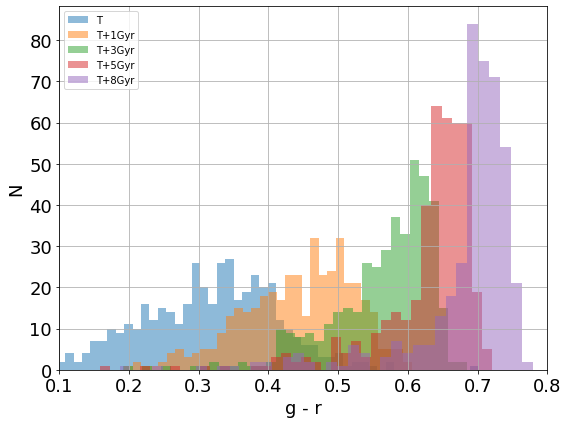

In [34]:
fig=figure(figsize=(8,6))
hist(grcolor.T[idsatqt,np.indices(idsatqt.shape)[0]][~idsatqtp10_ex],bins=50,alpha=0.5,label='T')
hist(grcolor.T[idsatqtp1,np.indices(idsatqtp1.shape)[0]][~idsatqtp10_ex],bins=50,alpha=0.5,label='T+1Gyr')
hist(grcolor.T[idsatqtp3,np.indices(idsatqtp1.shape)[0]][~idsatqtp10_ex],bins=50,alpha=0.5,label='T+3Gyr')
hist(grcolor.T[idsatqtp5,np.indices(idsatqtp1.shape)[0]][~idsatqtp10_ex],bins=50,alpha=0.5,label='T+5Gyr')
hist(grcolor.T[idsatqtp8,np.indices(idsatqtp1.shape)[0]][~idsatqtp10_ex],bins=50,alpha=0.5,label='T+8Gyr')
legend()
grid()
xlim(0.1,0.8)
xlabel('g - r', fontsize=18)
ylabel('N', fontsize=18)
tight_layout()
fig.savefig('plots/S_Fig3.pdf',dpi=300)